In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 304)
(884582, 3)
validation
(154411, 304)
(154411, 3)
test
(115112, 304)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1001731 (3.82 MB)


Trainable params: 1001731 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 37s - loss: 1.0813 - STD: 0.0333 - MAE: 0.4396

2/9 [=====>........................] - ETA: 0s - loss: 1.1147 - STD: 0.1128 - MAE: 0.4285 

3/9 [=========>....................] - ETA: 9s - loss: 1.1135 - STD: 0.1198 - MAE: 0.4282

4/9 [============>.................] - ETA: 5s - loss: 1.1065 - STD: 0.1112 - MAE: 0.4299

5/9 [===============>..............] - ETA: 3s - loss: 1.1028 - STD: 0.0921 - MAE: 0.4323

6/9 [===================>..........] - ETA: 2s - loss: 1.1027 - STD: 0.0837 - MAE: 0.4341

7/9 [======================>.......] - ETA: 1s - loss: 1.1014 - STD: 0.0805 - MAE: 0.4349

8/9 [=========================>....] - ETA: 0s - loss: 1.0985 - STD: 0.0799 - MAE: 0.4348

9/9 [==============================] - ETA: 0s - loss: 1.0959 - STD: 0.0809 - MAE: 0.4344

9/9 [==============================] - 10s 677ms/step - loss: 1.0959 - STD: 0.0809 - MAE: 0.4344 - val_loss: 1.0781 - val_STD: 0.1005 - val_MAE: 0.4297


Epoch 2/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0774 - STD: 0.1006 - MAE: 0.4295

2/9 [=====>........................] - ETA: 0s - loss: 1.0821 - STD: 0.1051 - MAE: 0.4295

3/9 [=========>....................] - ETA: 0s - loss: 1.0835 - STD: 0.1065 - MAE: 0.4294

4/9 [============>.................] - ETA: 0s - loss: 1.0821 - STD: 0.1052 - MAE: 0.4294

5/9 [===============>..............] - ETA: 0s - loss: 1.0803 - STD: 0.1025 - MAE: 0.4296

6/9 [===================>..........] - ETA: 0s - loss: 1.0791 - STD: 0.0992 - MAE: 0.4301

7/9 [======================>.......] - ETA: 0s - loss: 1.0781 - STD: 0.0952 - MAE: 0.4306

8/9 [=========================>....] - ETA: 0s - loss: 1.0778 - STD: 0.0907 - MAE: 0.4312

9/9 [==============================] - ETA: 0s - loss: 1.0777 - STD: 0.0862 - MAE: 0.4319

9/9 [==============================] - 1s 143ms/step - loss: 1.0777 - STD: 0.0862 - MAE: 0.4319 - val_loss: 1.0752 - val_STD: 0.0446 - val_MAE: 0.4373


Epoch 3/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0748 - STD: 0.0449 - MAE: 0.4372

2/9 [=====>........................] - ETA: 1s - loss: 1.0740 - STD: 0.0470 - MAE: 0.4368

3/9 [=========>....................] - ETA: 0s - loss: 1.0729 - STD: 0.0512 - MAE: 0.4362

4/9 [============>.................] - ETA: 0s - loss: 1.0720 - STD: 0.0564 - MAE: 0.4353

5/9 [===============>..............] - ETA: 0s - loss: 1.0715 - STD: 0.0619 - MAE: 0.4344

6/9 [===================>..........] - ETA: 0s - loss: 1.0714 - STD: 0.0671 - MAE: 0.4336

7/9 [======================>.......] - ETA: 0s - loss: 1.0713 - STD: 0.0714 - MAE: 0.4329

8/9 [=========================>....] - ETA: 0s - loss: 1.0712 - STD: 0.0744 - MAE: 0.4324

9/9 [==============================] - ETA: 0s - loss: 1.0709 - STD: 0.0760 - MAE: 0.4321

9/9 [==============================] - 1s 149ms/step - loss: 1.0709 - STD: 0.0760 - MAE: 0.4321 - val_loss: 1.0662 - val_STD: 0.0778 - val_MAE: 0.4312


Epoch 4/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0672 - STD: 0.0783 - MAE: 0.4313

2/9 [=====>........................] - ETA: 0s - loss: 1.0665 - STD: 0.0729 - MAE: 0.4319

3/9 [=========>....................] - ETA: 0s - loss: 1.0656 - STD: 0.0684 - MAE: 0.4323

4/9 [============>.................] - ETA: 0s - loss: 1.0652 - STD: 0.0654 - MAE: 0.4326

5/9 [===============>..............] - ETA: 0s - loss: 1.0645 - STD: 0.0642 - MAE: 0.4326

6/9 [===================>..........] - ETA: 0s - loss: 1.0638 - STD: 0.0645 - MAE: 0.4324

7/9 [======================>.......] - ETA: 0s - loss: 1.0630 - STD: 0.0657 - MAE: 0.4320

8/9 [=========================>....] - ETA: 0s - loss: 1.0621 - STD: 0.0670 - MAE: 0.4316

9/9 [==============================] - ETA: 0s - loss: 1.0610 - STD: 0.0681 - MAE: 0.4312

9/9 [==============================] - 1s 141ms/step - loss: 1.0610 - STD: 0.0681 - MAE: 0.4312 - val_loss: 1.0523 - val_STD: 0.0785 - val_MAE: 0.4275


Epoch 5/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0499 - STD: 0.0793 - MAE: 0.4267

2/9 [=====>........................] - ETA: 0s - loss: 1.0479 - STD: 0.0807 - MAE: 0.4259

3/9 [=========>....................] - ETA: 0s - loss: 1.0458 - STD: 0.0824 - MAE: 0.4251

4/9 [============>.................] - ETA: 0s - loss: 1.0441 - STD: 0.0843 - MAE: 0.4243

5/9 [===============>..............] - ETA: 0s - loss: 1.0415 - STD: 0.0850 - MAE: 0.4235

6/9 [===================>..........] - ETA: 0s - loss: 1.0390 - STD: 0.0844 - MAE: 0.4229

7/9 [======================>.......] - ETA: 0s - loss: 1.0358 - STD: 0.0835 - MAE: 0.4223

8/9 [=========================>....] - ETA: 0s - loss: 1.0324 - STD: 0.0834 - MAE: 0.4215

9/9 [==============================] - ETA: 0s - loss: 1.0287 - STD: 0.0844 - MAE: 0.4205

9/9 [==============================] - 1s 147ms/step - loss: 1.0287 - STD: 0.0844 - MAE: 0.4205 - val_loss: 0.9978 - val_STD: 0.0944 - val_MAE: 0.4114


Epoch 6/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9878 - STD: 0.0967 - MAE: 0.4083

2/9 [=====>........................] - ETA: 0s - loss: 0.9820 - STD: 0.1007 - MAE: 0.4061

3/9 [=========>....................] - ETA: 0s - loss: 0.9761 - STD: 0.1079 - MAE: 0.4030

4/9 [============>.................] - ETA: 0s - loss: 0.9704 - STD: 0.1146 - MAE: 0.4001

5/9 [===============>..............] - ETA: 0s - loss: 0.9652 - STD: 0.1210 - MAE: 0.3973

6/9 [===================>..........] - ETA: 0s - loss: 0.9601 - STD: 0.1279 - MAE: 0.3942

7/9 [======================>.......] - ETA: 0s - loss: 0.9557 - STD: 0.1340 - MAE: 0.3916

8/9 [=========================>....] - ETA: 0s - loss: 0.9524 - STD: 0.1406 - MAE: 0.3887

9/9 [==============================] - ETA: 0s - loss: 0.9496 - STD: 0.1452 - MAE: 0.3869

9/9 [==============================] - 1s 140ms/step - loss: 0.9496 - STD: 0.1452 - MAE: 0.3869 - val_loss: 0.9659 - val_STD: 0.2170 - val_MAE: 0.3647


Epoch 7/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9348 - STD: 0.2156 - MAE: 0.3588

2/9 [=====>........................] - ETA: 0s - loss: 0.9240 - STD: 0.2070 - MAE: 0.3603

3/9 [=========>....................] - ETA: 0s - loss: 0.9265 - STD: 0.2026 - MAE: 0.3631

4/9 [============>.................] - ETA: 0s - loss: 0.9235 - STD: 0.2056 - MAE: 0.3611

5/9 [===============>..............] - ETA: 0s - loss: 0.9241 - STD: 0.2101 - MAE: 0.3591

6/9 [===================>..........] - ETA: 0s - loss: 0.9223 - STD: 0.2099 - MAE: 0.3590

7/9 [======================>.......] - ETA: 0s - loss: 0.9221 - STD: 0.2097 - MAE: 0.3592

8/9 [=========================>....] - ETA: 0s - loss: 0.9212 - STD: 0.2119 - MAE: 0.3581

9/9 [==============================] - ETA: 0s - loss: 0.9205 - STD: 0.2139 - MAE: 0.3570

9/9 [==============================] - 1s 142ms/step - loss: 0.9205 - STD: 0.2139 - MAE: 0.3570 - val_loss: 0.9500 - val_STD: 0.2134 - val_MAE: 0.3643


Epoch 8/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.9086 - STD: 0.2102 - MAE: 0.3570

2/9 [=====>........................] - ETA: 0s - loss: 0.9108 - STD: 0.2071 - MAE: 0.3587

3/9 [=========>....................] - ETA: 0s - loss: 0.9088 - STD: 0.2088 - MAE: 0.3575

4/9 [============>.................] - ETA: 0s - loss: 0.9081 - STD: 0.2104 - MAE: 0.3565

5/9 [===============>..............] - ETA: 0s - loss: 0.9067 - STD: 0.2082 - MAE: 0.3571

6/9 [===================>..........] - ETA: 0s - loss: 0.9062 - STD: 0.2049 - MAE: 0.3584

7/9 [======================>.......] - ETA: 0s - loss: 0.9052 - STD: 0.2030 - MAE: 0.3589

8/9 [=========================>....] - ETA: 0s - loss: 0.9046 - STD: 0.2029 - MAE: 0.3588

9/9 [==============================] - ETA: 0s - loss: 0.9041 - STD: 0.2028 - MAE: 0.3588

9/9 [==============================] - 1s 144ms/step - loss: 0.9041 - STD: 0.2028 - MAE: 0.3588 - val_loss: 0.9301 - val_STD: 0.1939 - val_MAE: 0.3685


Epoch 9/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8954 - STD: 0.1902 - MAE: 0.3621

2/9 [=====>........................] - ETA: 0s - loss: 0.8984 - STD: 0.1887 - MAE: 0.3634

3/9 [=========>....................] - ETA: 0s - loss: 0.8984 - STD: 0.1904 - MAE: 0.3627

4/9 [============>.................] - ETA: 0s - loss: 0.8984 - STD: 0.1936 - MAE: 0.3614

5/9 [===============>..............] - ETA: 0s - loss: 0.8973 - STD: 0.1945 - MAE: 0.3608

6/9 [===================>..........] - ETA: 0s - loss: 0.8969 - STD: 0.1939 - MAE: 0.3610

7/9 [======================>.......] - ETA: 0s - loss: 0.8962 - STD: 0.1939 - MAE: 0.3608

8/9 [=========================>....] - ETA: 0s - loss: 0.8959 - STD: 0.1953 - MAE: 0.3602

9/9 [==============================] - ETA: 0s - loss: 0.8955 - STD: 0.1968 - MAE: 0.3595

9/9 [==============================] - 1s 141ms/step - loss: 0.8955 - STD: 0.1968 - MAE: 0.3595 - val_loss: 0.9269 - val_STD: 0.2082 - val_MAE: 0.3616


Epoch 10/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8900 - STD: 0.2044 - MAE: 0.3551

2/9 [=====>........................] - ETA: 0s - loss: 0.8898 - STD: 0.2049 - MAE: 0.3549

3/9 [=========>....................] - ETA: 0s - loss: 0.8887 - STD: 0.2078 - MAE: 0.3535

4/9 [============>.................] - ETA: 0s - loss: 0.8883 - STD: 0.2101 - MAE: 0.3524

5/9 [===============>..............] - ETA: 0s - loss: 0.8881 - STD: 0.2107 - MAE: 0.3521

6/9 [===================>..........] - ETA: 0s - loss: 0.8873 - STD: 0.2109 - MAE: 0.3519

7/9 [======================>.......] - ETA: 0s - loss: 0.8868 - STD: 0.2117 - MAE: 0.3515

8/9 [=========================>....] - ETA: 0s - loss: 0.8865 - STD: 0.2124 - MAE: 0.3511

9/9 [==============================] - ETA: 0s - loss: 0.8862 - STD: 0.2122 - MAE: 0.3511

9/9 [==============================] - 1s 141ms/step - loss: 0.8862 - STD: 0.2122 - MAE: 0.3511 - val_loss: 0.9226 - val_STD: 0.2144 - val_MAE: 0.3578


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8826 - STD: 0.2110 - MAE: 0.3508

2/9 [=====>........................] - ETA: 0s - loss: 0.8802 - STD: 0.2134 - MAE: 0.3493

3/9 [=========>....................] - ETA: 0s - loss: 0.8799 - STD: 0.2143 - MAE: 0.3488

4/9 [============>.................] - ETA: 0s - loss: 0.8791 - STD: 0.2137 - MAE: 0.3490

5/9 [===============>..............] - ETA: 0s - loss: 0.8788 - STD: 0.2132 - MAE: 0.3491

6/9 [===================>..........] - ETA: 0s - loss: 0.8788 - STD: 0.2132 - MAE: 0.3492

7/9 [======================>.......] - ETA: 0s - loss: 0.8784 - STD: 0.2132 - MAE: 0.3491

8/9 [=========================>....] - ETA: 0s - loss: 0.8781 - STD: 0.2128 - MAE: 0.3492

9/9 [==============================] - ETA: 0s - loss: 0.8780 - STD: 0.2125 - MAE: 0.3493

9/9 [==============================] - 1s 145ms/step - loss: 0.8780 - STD: 0.2125 - MAE: 0.3493 - val_loss: 0.9117 - val_STD: 0.2180 - val_MAE: 0.3543


Epoch 12/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8776 - STD: 0.2131 - MAE: 0.3491

2/9 [=====>........................] - ETA: 0s - loss: 0.8752 - STD: 0.2127 - MAE: 0.3487

3/9 [=========>....................] - ETA: 0s - loss: 0.8738 - STD: 0.2126 - MAE: 0.3484

4/9 [============>.................] - ETA: 0s - loss: 0.8728 - STD: 0.2135 - MAE: 0.3479

5/9 [===============>..............] - ETA: 0s - loss: 0.8721 - STD: 0.2143 - MAE: 0.3473

6/9 [===================>..........] - ETA: 0s - loss: 0.8714 - STD: 0.2147 - MAE: 0.3470

7/9 [======================>.......] - ETA: 0s - loss: 0.8714 - STD: 0.2152 - MAE: 0.3468

8/9 [=========================>....] - ETA: 0s - loss: 0.8706 - STD: 0.2158 - MAE: 0.3464

9/9 [==============================] - ETA: 0s - loss: 0.8698 - STD: 0.2164 - MAE: 0.3459

9/9 [==============================] - 1s 142ms/step - loss: 0.8698 - STD: 0.2164 - MAE: 0.3459 - val_loss: 0.9069 - val_STD: 0.2243 - val_MAE: 0.3503


Epoch 13/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8619 - STD: 0.2198 - MAE: 0.3428

2/9 [=====>........................] - ETA: 0s - loss: 0.8640 - STD: 0.2208 - MAE: 0.3429

3/9 [=========>....................] - ETA: 0s - loss: 0.8649 - STD: 0.2211 - MAE: 0.3429

4/9 [============>.................] - ETA: 0s - loss: 0.8650 - STD: 0.2213 - MAE: 0.3428

5/9 [===============>..............] - ETA: 0s - loss: 0.8647 - STD: 0.2214 - MAE: 0.3427

6/9 [===================>..........] - ETA: 0s - loss: 0.8642 - STD: 0.2216 - MAE: 0.3425

7/9 [======================>.......] - ETA: 0s - loss: 0.8630 - STD: 0.2221 - MAE: 0.3421

8/9 [=========================>....] - ETA: 0s - loss: 0.8621 - STD: 0.2223 - MAE: 0.3418

9/9 [==============================] - ETA: 0s - loss: 0.8615 - STD: 0.2224 - MAE: 0.3416

9/9 [==============================] - 1s 140ms/step - loss: 0.8615 - STD: 0.2224 - MAE: 0.3416 - val_loss: 0.8980 - val_STD: 0.2305 - val_MAE: 0.3458


Epoch 14/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8547 - STD: 0.2256 - MAE: 0.3388

2/9 [=====>........................] - ETA: 0s - loss: 0.8565 - STD: 0.2246 - MAE: 0.3396

3/9 [=========>....................] - ETA: 0s - loss: 0.8557 - STD: 0.2235 - MAE: 0.3399

4/9 [============>.................] - ETA: 0s - loss: 0.8559 - STD: 0.2247 - MAE: 0.3395

5/9 [===============>..............] - ETA: 0s - loss: 0.8559 - STD: 0.2237 - MAE: 0.3399

6/9 [===================>..........] - ETA: 0s - loss: 0.8551 - STD: 0.2246 - MAE: 0.3394

7/9 [======================>.......] - ETA: 0s - loss: 0.8549 - STD: 0.2254 - MAE: 0.3390

8/9 [=========================>....] - ETA: 0s - loss: 0.8546 - STD: 0.2248 - MAE: 0.3392

9/9 [==============================] - ETA: 0s - loss: 0.8543 - STD: 0.2264 - MAE: 0.3384

9/9 [==============================] - 1s 142ms/step - loss: 0.8543 - STD: 0.2264 - MAE: 0.3384 - val_loss: 0.8920 - val_STD: 0.2298 - val_MAE: 0.3446


Epoch 15/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8496 - STD: 0.2241 - MAE: 0.3385

2/9 [=====>........................] - ETA: 0s - loss: 0.8477 - STD: 0.2251 - MAE: 0.3376

3/9 [=========>....................] - ETA: 0s - loss: 0.8493 - STD: 0.2299 - MAE: 0.3358

4/9 [============>.................] - ETA: 0s - loss: 0.8493 - STD: 0.2275 - MAE: 0.3369

5/9 [===============>..............] - ETA: 0s - loss: 0.8484 - STD: 0.2290 - MAE: 0.3360

6/9 [===================>..........] - ETA: 0s - loss: 0.8480 - STD: 0.2298 - MAE: 0.3356

7/9 [======================>.......] - ETA: 0s - loss: 0.8479 - STD: 0.2285 - MAE: 0.3361

8/9 [=========================>....] - ETA: 0s - loss: 0.8486 - STD: 0.2305 - MAE: 0.3353

9/9 [==============================] - ETA: 0s - loss: 0.8484 - STD: 0.2297 - MAE: 0.3357

9/9 [==============================] - 1s 149ms/step - loss: 0.8484 - STD: 0.2297 - MAE: 0.3357 - val_loss: 0.8829 - val_STD: 0.2352 - val_MAE: 0.3404


Epoch 16/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8448 - STD: 0.2292 - MAE: 0.3352

2/9 [=====>........................] - ETA: 0s - loss: 0.8439 - STD: 0.2347 - MAE: 0.3325

3/9 [=========>....................] - ETA: 0s - loss: 0.8437 - STD: 0.2303 - MAE: 0.3345

4/9 [============>.................] - ETA: 0s - loss: 0.8439 - STD: 0.2329 - MAE: 0.3333

5/9 [===============>..............] - ETA: 0s - loss: 0.8430 - STD: 0.2330 - MAE: 0.3331

6/9 [===================>..........] - ETA: 0s - loss: 0.8426 - STD: 0.2316 - MAE: 0.3337

7/9 [======================>.......] - ETA: 0s - loss: 0.8427 - STD: 0.2332 - MAE: 0.3330

8/9 [=========================>....] - ETA: 0s - loss: 0.8425 - STD: 0.2325 - MAE: 0.3332

9/9 [==============================] - ETA: 0s - loss: 0.8416 - STD: 0.2329 - MAE: 0.3329

9/9 [==============================] - 1s 153ms/step - loss: 0.8416 - STD: 0.2329 - MAE: 0.3329 - val_loss: 0.8776 - val_STD: 0.2456 - val_MAE: 0.3344


Epoch 17/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8387 - STD: 0.2402 - MAE: 0.3290

2/9 [=====>........................] - ETA: 0s - loss: 0.8397 - STD: 0.2333 - MAE: 0.3323

3/9 [=========>....................] - ETA: 0s - loss: 0.8378 - STD: 0.2369 - MAE: 0.3303

4/9 [============>.................] - ETA: 0s - loss: 0.8368 - STD: 0.2367 - MAE: 0.3301

5/9 [===============>..............] - ETA: 0s - loss: 0.8367 - STD: 0.2351 - MAE: 0.3308

6/9 [===================>..........] - ETA: 0s - loss: 0.8368 - STD: 0.2374 - MAE: 0.3298

7/9 [======================>.......] - ETA: 0s - loss: 0.8367 - STD: 0.2362 - MAE: 0.3303

8/9 [=========================>....] - ETA: 0s - loss: 0.8364 - STD: 0.2367 - MAE: 0.3301

9/9 [==============================] - ETA: 0s - loss: 0.8363 - STD: 0.2368 - MAE: 0.3300

9/9 [==============================] - 1s 153ms/step - loss: 0.8363 - STD: 0.2368 - MAE: 0.3300 - val_loss: 0.8775 - val_STD: 0.2356 - val_MAE: 0.3388


Epoch 18/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8366 - STD: 0.2292 - MAE: 0.3334

2/9 [=====>........................] - ETA: 0s - loss: 0.8359 - STD: 0.2407 - MAE: 0.3280

3/9 [=========>....................] - ETA: 0s - loss: 0.8364 - STD: 0.2366 - MAE: 0.3300

4/9 [============>.................] - ETA: 0s - loss: 0.8353 - STD: 0.2385 - MAE: 0.3289

5/9 [===============>..............] - ETA: 0s - loss: 0.8345 - STD: 0.2381 - MAE: 0.3290

6/9 [===================>..........] - ETA: 0s - loss: 0.8337 - STD: 0.2372 - MAE: 0.3292

7/9 [======================>.......] - ETA: 0s - loss: 0.8330 - STD: 0.2381 - MAE: 0.3287

8/9 [=========================>....] - ETA: 0s - loss: 0.8327 - STD: 0.2374 - MAE: 0.3290

9/9 [==============================] - ETA: 0s - loss: 0.8321 - STD: 0.2377 - MAE: 0.3287

9/9 [==============================] - 1s 146ms/step - loss: 0.8321 - STD: 0.2377 - MAE: 0.3287 - val_loss: 0.8693 - val_STD: 0.2521 - val_MAE: 0.3295


Epoch 19/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8296 - STD: 0.2460 - MAE: 0.3244

2/9 [=====>........................] - ETA: 0s - loss: 0.8294 - STD: 0.2393 - MAE: 0.3275

3/9 [=========>....................] - ETA: 0s - loss: 0.8311 - STD: 0.2442 - MAE: 0.3255

4/9 [============>.................] - ETA: 0s - loss: 0.8318 - STD: 0.2402 - MAE: 0.3274

5/9 [===============>..............] - ETA: 0s - loss: 0.8318 - STD: 0.2418 - MAE: 0.3267

6/9 [===================>..........] - ETA: 0s - loss: 0.8307 - STD: 0.2412 - MAE: 0.3268

7/9 [======================>.......] - ETA: 0s - loss: 0.8299 - STD: 0.2407 - MAE: 0.3268

8/9 [=========================>....] - ETA: 0s - loss: 0.8298 - STD: 0.2423 - MAE: 0.3261

9/9 [==============================] - ETA: 0s - loss: 0.8301 - STD: 0.2411 - MAE: 0.3267

9/9 [==============================] - 1s 138ms/step - loss: 0.8301 - STD: 0.2411 - MAE: 0.3267 - val_loss: 0.8693 - val_STD: 0.2586 - val_MAE: 0.3264


Epoch 20/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8323 - STD: 0.2525 - MAE: 0.3218

2/9 [=====>........................] - ETA: 0s - loss: 0.8291 - STD: 0.2429 - MAE: 0.3256

3/9 [=========>....................] - ETA: 0s - loss: 0.8262 - STD: 0.2405 - MAE: 0.3262

4/9 [============>.................] - ETA: 0s - loss: 0.8270 - STD: 0.2437 - MAE: 0.3248

5/9 [===============>..............] - ETA: 0s - loss: 0.8280 - STD: 0.2409 - MAE: 0.3264

6/9 [===================>..........] - ETA: 0s - loss: 0.8276 - STD: 0.2428 - MAE: 0.3254

7/9 [======================>.......] - ETA: 0s - loss: 0.8266 - STD: 0.2423 - MAE: 0.3255

8/9 [=========================>....] - ETA: 0s - loss: 0.8265 - STD: 0.2414 - MAE: 0.3259

9/9 [==============================] - ETA: 0s - loss: 0.8264 - STD: 0.2423 - MAE: 0.3254

9/9 [==============================] - 1s 151ms/step - loss: 0.8264 - STD: 0.2423 - MAE: 0.3254 - val_loss: 0.8658 - val_STD: 0.2429 - val_MAE: 0.3331


Epoch 21/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8262 - STD: 0.2363 - MAE: 0.3283

2/9 [=====>........................] - ETA: 0s - loss: 0.8223 - STD: 0.2402 - MAE: 0.3256

3/9 [=========>....................] - ETA: 0s - loss: 0.8216 - STD: 0.2422 - MAE: 0.3245

4/9 [============>.................] - ETA: 0s - loss: 0.8211 - STD: 0.2412 - MAE: 0.3249

5/9 [===============>..............] - ETA: 0s - loss: 0.8220 - STD: 0.2440 - MAE: 0.3237

6/9 [===================>..........] - ETA: 0s - loss: 0.8220 - STD: 0.2427 - MAE: 0.3243

7/9 [======================>.......] - ETA: 0s - loss: 0.8215 - STD: 0.2434 - MAE: 0.3239

8/9 [=========================>....] - ETA: 0s - loss: 0.8215 - STD: 0.2435 - MAE: 0.3239

9/9 [==============================] - ETA: 0s - loss: 0.8214 - STD: 0.2429 - MAE: 0.3241

9/9 [==============================] - 1s 143ms/step - loss: 0.8214 - STD: 0.2429 - MAE: 0.3241 - val_loss: 0.8647 - val_STD: 0.2621 - val_MAE: 0.3236


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8249 - STD: 0.2563 - MAE: 0.3182

2/9 [=====>........................] - ETA: 0s - loss: 0.8241 - STD: 0.2456 - MAE: 0.3233

3/9 [=========>....................] - ETA: 0s - loss: 0.8228 - STD: 0.2480 - MAE: 0.3219

4/9 [============>.................] - ETA: 0s - loss: 0.8209 - STD: 0.2458 - MAE: 0.3225

5/9 [===============>..............] - ETA: 0s - loss: 0.8206 - STD: 0.2449 - MAE: 0.3230

6/9 [===================>..........] - ETA: 0s - loss: 0.8205 - STD: 0.2465 - MAE: 0.3222

7/9 [======================>.......] - ETA: 0s - loss: 0.8206 - STD: 0.2450 - MAE: 0.3229

8/9 [=========================>....] - ETA: 0s - loss: 0.8206 - STD: 0.2460 - MAE: 0.3224

9/9 [==============================] - ETA: 0s - loss: 0.8200 - STD: 0.2452 - MAE: 0.3227

9/9 [==============================] - 1s 155ms/step - loss: 0.8200 - STD: 0.2452 - MAE: 0.3227 - val_loss: 0.8580 - val_STD: 0.2516 - val_MAE: 0.3273


Epoch 23/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8141 - STD: 0.2466 - MAE: 0.3208

2/9 [=====>........................] - ETA: 0s - loss: 0.8149 - STD: 0.2494 - MAE: 0.3197

3/9 [=========>....................] - ETA: 0s - loss: 0.8148 - STD: 0.2460 - MAE: 0.3213

4/9 [============>.................] - ETA: 0s - loss: 0.8149 - STD: 0.2475 - MAE: 0.3206

5/9 [===============>..............] - ETA: 0s - loss: 0.8151 - STD: 0.2459 - MAE: 0.3214

6/9 [===================>..........] - ETA: 0s - loss: 0.8147 - STD: 0.2460 - MAE: 0.3213

7/9 [======================>.......] - ETA: 0s - loss: 0.8141 - STD: 0.2468 - MAE: 0.3208

8/9 [=========================>....] - ETA: 0s - loss: 0.8143 - STD: 0.2461 - MAE: 0.3212

9/9 [==============================] - ETA: 0s - loss: 0.8139 - STD: 0.2471 - MAE: 0.3206

9/9 [==============================] - 1s 139ms/step - loss: 0.8139 - STD: 0.2471 - MAE: 0.3206 - val_loss: 0.8596 - val_STD: 0.2470 - val_MAE: 0.3297


Epoch 24/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8129 - STD: 0.2410 - MAE: 0.3233

2/9 [=====>........................] - ETA: 1s - loss: 0.8112 - STD: 0.2451 - MAE: 0.3210

3/9 [=========>....................] - ETA: 0s - loss: 0.8118 - STD: 0.2464 - MAE: 0.3205

4/9 [============>.................] - ETA: 0s - loss: 0.8111 - STD: 0.2460 - MAE: 0.3206

5/9 [===============>..............] - ETA: 0s - loss: 0.8107 - STD: 0.2473 - MAE: 0.3198

6/9 [===================>..........] - ETA: 0s - loss: 0.8100 - STD: 0.2463 - MAE: 0.3202

7/9 [======================>.......] - ETA: 0s - loss: 0.8095 - STD: 0.2474 - MAE: 0.3195

8/9 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2468 - MAE: 0.3198

9/9 [==============================] - ETA: 0s - loss: 0.8095 - STD: 0.2480 - MAE: 0.3192

9/9 [==============================] - 1s 145ms/step - loss: 0.8095 - STD: 0.2480 - MAE: 0.3192 - val_loss: 0.8619 - val_STD: 0.2462 - val_MAE: 0.3305


Epoch 25/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8125 - STD: 0.2401 - MAE: 0.3236

2/9 [=====>........................] - ETA: 0s - loss: 0.8118 - STD: 0.2487 - MAE: 0.3193

3/9 [=========>....................] - ETA: 0s - loss: 0.8117 - STD: 0.2466 - MAE: 0.3203

4/9 [============>.................] - ETA: 0s - loss: 0.8109 - STD: 0.2497 - MAE: 0.3186

5/9 [===============>..............] - ETA: 0s - loss: 0.8106 - STD: 0.2480 - MAE: 0.3193

6/9 [===================>..........] - ETA: 0s - loss: 0.8102 - STD: 0.2493 - MAE: 0.3186

7/9 [======================>.......] - ETA: 0s - loss: 0.8091 - STD: 0.2485 - MAE: 0.3188

8/9 [=========================>....] - ETA: 0s - loss: 0.8076 - STD: 0.2488 - MAE: 0.3183

9/9 [==============================] - ETA: 0s - loss: 0.8067 - STD: 0.2496 - MAE: 0.3177

9/9 [==============================] - 1s 137ms/step - loss: 0.8067 - STD: 0.2496 - MAE: 0.3177 - val_loss: 0.8602 - val_STD: 0.2497 - val_MAE: 0.3284


Epoch 26/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8051 - STD: 0.2444 - MAE: 0.3200

2/9 [=====>........................] - ETA: 0s - loss: 0.8123 - STD: 0.2530 - MAE: 0.3171

3/9 [=========>....................] - ETA: 0s - loss: 0.8127 - STD: 0.2487 - MAE: 0.3193

4/9 [============>.................] - ETA: 0s - loss: 0.8115 - STD: 0.2520 - MAE: 0.3175

5/9 [===============>..............] - ETA: 0s - loss: 0.8089 - STD: 0.2514 - MAE: 0.3172

6/9 [===================>..........] - ETA: 0s - loss: 0.8076 - STD: 0.2501 - MAE: 0.3177

7/9 [======================>.......] - ETA: 0s - loss: 0.8073 - STD: 0.2516 - MAE: 0.3168

8/9 [=========================>....] - ETA: 0s - loss: 0.8067 - STD: 0.2507 - MAE: 0.3171

9/9 [==============================] - ETA: 0s - loss: 0.8056 - STD: 0.2509 - MAE: 0.3168

9/9 [==============================] - 1s 145ms/step - loss: 0.8056 - STD: 0.2509 - MAE: 0.3168 - val_loss: 0.8478 - val_STD: 0.2585 - val_MAE: 0.3215


Epoch 27/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7962 - STD: 0.2518 - MAE: 0.3143

2/9 [=====>........................] - ETA: 0s - loss: 0.7981 - STD: 0.2508 - MAE: 0.3154

3/9 [=========>....................] - ETA: 0s - loss: 0.8012 - STD: 0.2540 - MAE: 0.3145

4/9 [============>.................] - ETA: 0s - loss: 0.8016 - STD: 0.2519 - MAE: 0.3156

5/9 [===============>..............] - ETA: 0s - loss: 0.8001 - STD: 0.2528 - MAE: 0.3148

6/9 [===================>..........] - ETA: 0s - loss: 0.7995 - STD: 0.2541 - MAE: 0.3140

7/9 [======================>.......] - ETA: 0s - loss: 0.7989 - STD: 0.2535 - MAE: 0.3142

8/9 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2537 - MAE: 0.3139

9/9 [==============================] - ETA: 0s - loss: 0.7977 - STD: 0.2542 - MAE: 0.3136

9/9 [==============================] - 1s 147ms/step - loss: 0.7977 - STD: 0.2542 - MAE: 0.3136 - val_loss: 0.8521 - val_STD: 0.2622 - val_MAE: 0.3202


Epoch 28/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7933 - STD: 0.2551 - MAE: 0.3121

2/9 [=====>........................] - ETA: 0s - loss: 0.7955 - STD: 0.2552 - MAE: 0.3125

3/9 [=========>....................] - ETA: 0s - loss: 0.7945 - STD: 0.2546 - MAE: 0.3127

4/9 [============>.................] - ETA: 0s - loss: 0.7944 - STD: 0.2559 - MAE: 0.3120

5/9 [===============>..............] - ETA: 0s - loss: 0.7939 - STD: 0.2556 - MAE: 0.3120

6/9 [===================>..........] - ETA: 0s - loss: 0.7934 - STD: 0.2549 - MAE: 0.3122

7/9 [======================>.......] - ETA: 0s - loss: 0.7932 - STD: 0.2559 - MAE: 0.3117

8/9 [=========================>....] - ETA: 0s - loss: 0.7926 - STD: 0.2559 - MAE: 0.3115

9/9 [==============================] - ETA: 0s - loss: 0.7924 - STD: 0.2560 - MAE: 0.3114

9/9 [==============================] - 1s 147ms/step - loss: 0.7924 - STD: 0.2560 - MAE: 0.3114 - val_loss: 0.8496 - val_STD: 0.2657 - val_MAE: 0.3176


Epoch 29/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7860 - STD: 0.2564 - MAE: 0.3100

2/9 [=====>........................] - ETA: 0s - loss: 0.7878 - STD: 0.2588 - MAE: 0.3091

3/9 [=========>....................] - ETA: 0s - loss: 0.7887 - STD: 0.2583 - MAE: 0.3095

4/9 [============>.................] - ETA: 0s - loss: 0.7895 - STD: 0.2581 - MAE: 0.3098

5/9 [===============>..............] - ETA: 0s - loss: 0.7904 - STD: 0.2593 - MAE: 0.3094

6/9 [===================>..........] - ETA: 0s - loss: 0.7902 - STD: 0.2590 - MAE: 0.3095

7/9 [======================>.......] - ETA: 0s - loss: 0.7906 - STD: 0.2593 - MAE: 0.3093

8/9 [=========================>....] - ETA: 0s - loss: 0.7903 - STD: 0.2596 - MAE: 0.3091

9/9 [==============================] - ETA: 0s - loss: 0.7903 - STD: 0.2597 - MAE: 0.3091

9/9 [==============================] - 1s 143ms/step - loss: 0.7903 - STD: 0.2597 - MAE: 0.3091 - val_loss: 0.8515 - val_STD: 0.2656 - val_MAE: 0.3179


Epoch 30/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7879 - STD: 0.2550 - MAE: 0.3111

2/9 [=====>........................] - ETA: 0s - loss: 0.7861 - STD: 0.2575 - MAE: 0.3094

3/9 [=========>....................] - ETA: 0s - loss: 0.7871 - STD: 0.2583 - MAE: 0.3092

4/9 [============>.................] - ETA: 0s - loss: 0.7869 - STD: 0.2577 - MAE: 0.3094

5/9 [===============>..............] - ETA: 0s - loss: 0.7869 - STD: 0.2580 - MAE: 0.3092

6/9 [===================>..........] - ETA: 0s - loss: 0.7873 - STD: 0.2585 - MAE: 0.3091

7/9 [======================>.......] - ETA: 0s - loss: 0.7873 - STD: 0.2587 - MAE: 0.3090

8/9 [=========================>....] - ETA: 0s - loss: 0.7870 - STD: 0.2585 - MAE: 0.3090

9/9 [==============================] - ETA: 0s - loss: 0.7866 - STD: 0.2590 - MAE: 0.3087

9/9 [==============================] - 1s 140ms/step - loss: 0.7866 - STD: 0.2590 - MAE: 0.3087 - val_loss: 0.8486 - val_STD: 0.2705 - val_MAE: 0.3147


Epoch 31/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7822 - STD: 0.2613 - MAE: 0.3066

2/9 [=====>........................] - ETA: 0s - loss: 0.7831 - STD: 0.2604 - MAE: 0.3072

3/9 [=========>....................] - ETA: 0s - loss: 0.7848 - STD: 0.2601 - MAE: 0.3078

4/9 [============>.................] - ETA: 0s - loss: 0.7861 - STD: 0.2608 - MAE: 0.3077

5/9 [===============>..............] - ETA: 0s - loss: 0.7860 - STD: 0.2599 - MAE: 0.3081

6/9 [===================>..........] - ETA: 0s - loss: 0.7860 - STD: 0.2604 - MAE: 0.3078

7/9 [======================>.......] - ETA: 0s - loss: 0.7858 - STD: 0.2605 - MAE: 0.3078

8/9 [=========================>....] - ETA: 0s - loss: 0.7855 - STD: 0.2605 - MAE: 0.3077

9/9 [==============================] - ETA: 0s - loss: 0.7855 - STD: 0.2603 - MAE: 0.3078

9/9 [==============================] - 1s 147ms/step - loss: 0.7855 - STD: 0.2603 - MAE: 0.3078 - val_loss: 0.8463 - val_STD: 0.2724 - val_MAE: 0.3133


Epoch 32/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7840 - STD: 0.2631 - MAE: 0.3061

2/9 [=====>........................] - ETA: 0s - loss: 0.7844 - STD: 0.2611 - MAE: 0.3072

3/9 [=========>....................] - ETA: 0s - loss: 0.7826 - STD: 0.2614 - MAE: 0.3066

4/9 [============>.................] - ETA: 0s - loss: 0.7825 - STD: 0.2616 - MAE: 0.3065

5/9 [===============>..............] - ETA: 0s - loss: 0.7826 - STD: 0.2614 - MAE: 0.3066

6/9 [===================>..........] - ETA: 0s - loss: 0.7832 - STD: 0.2615 - MAE: 0.3067

7/9 [======================>.......] - ETA: 0s - loss: 0.7835 - STD: 0.2614 - MAE: 0.3068

8/9 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2620 - MAE: 0.3067

9/9 [==============================] - ETA: 0s - loss: 0.7848 - STD: 0.2616 - MAE: 0.3070

9/9 [==============================] - 1s 149ms/step - loss: 0.7848 - STD: 0.2616 - MAE: 0.3070 - val_loss: 0.8503 - val_STD: 0.2747 - val_MAE: 0.3128


Epoch 33/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7925 - STD: 0.2667 - MAE: 0.3059

2/9 [=====>........................] - ETA: 0s - loss: 0.7886 - STD: 0.2633 - MAE: 0.3070

3/9 [=========>....................] - ETA: 0s - loss: 0.7882 - STD: 0.2635 - MAE: 0.3068

4/9 [============>.................] - ETA: 0s - loss: 0.7871 - STD: 0.2619 - MAE: 0.3073

5/9 [===============>..............] - ETA: 0s - loss: 0.7862 - STD: 0.2617 - MAE: 0.3073

6/9 [===================>..........] - ETA: 0s - loss: 0.7853 - STD: 0.2620 - MAE: 0.3069

7/9 [======================>.......] - ETA: 0s - loss: 0.7848 - STD: 0.2611 - MAE: 0.3073

8/9 [=========================>....] - ETA: 0s - loss: 0.7842 - STD: 0.2612 - MAE: 0.3071

9/9 [==============================] - ETA: 0s - loss: 0.7838 - STD: 0.2613 - MAE: 0.3070

9/9 [==============================] - 1s 148ms/step - loss: 0.7838 - STD: 0.2613 - MAE: 0.3070 - val_loss: 0.8446 - val_STD: 0.2691 - val_MAE: 0.3147


Epoch 34/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7770 - STD: 0.2598 - MAE: 0.3063

2/9 [=====>........................] - ETA: 0s - loss: 0.7799 - STD: 0.2596 - MAE: 0.3071

3/9 [=========>....................] - ETA: 0s - loss: 0.7787 - STD: 0.2608 - MAE: 0.3062

4/9 [============>.................] - ETA: 0s - loss: 0.7784 - STD: 0.2616 - MAE: 0.3057

5/9 [===============>..............] - ETA: 0s - loss: 0.7785 - STD: 0.2613 - MAE: 0.3059

6/9 [===================>..........] - ETA: 0s - loss: 0.7789 - STD: 0.2615 - MAE: 0.3059

7/9 [======================>.......] - ETA: 0s - loss: 0.7791 - STD: 0.2617 - MAE: 0.3058

8/9 [=========================>....] - ETA: 0s - loss: 0.7796 - STD: 0.2621 - MAE: 0.3057

9/9 [==============================] - ETA: 0s - loss: 0.7800 - STD: 0.2620 - MAE: 0.3058

9/9 [==============================] - 1s 142ms/step - loss: 0.7800 - STD: 0.2620 - MAE: 0.3058 - val_loss: 0.8473 - val_STD: 0.2774 - val_MAE: 0.3107


Epoch 35/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7874 - STD: 0.2684 - MAE: 0.3040

2/9 [=====>........................] - ETA: 0s - loss: 0.7866 - STD: 0.2640 - MAE: 0.3061

3/9 [=========>....................] - ETA: 0s - loss: 0.7860 - STD: 0.2643 - MAE: 0.3059

4/9 [============>.................] - ETA: 0s - loss: 0.7853 - STD: 0.2634 - MAE: 0.3062

5/9 [===============>..............] - ETA: 0s - loss: 0.7837 - STD: 0.2635 - MAE: 0.3057

6/9 [===================>..........] - ETA: 0s - loss: 0.7821 - STD: 0.2632 - MAE: 0.3056

7/9 [======================>.......] - ETA: 0s - loss: 0.7811 - STD: 0.2633 - MAE: 0.3053

8/9 [=========================>....] - ETA: 0s - loss: 0.7808 - STD: 0.2631 - MAE: 0.3054

9/9 [==============================] - ETA: 0s - loss: 0.7802 - STD: 0.2628 - MAE: 0.3054

9/9 [==============================] - 1s 144ms/step - loss: 0.7802 - STD: 0.2628 - MAE: 0.3054 - val_loss: 0.8441 - val_STD: 0.2772 - val_MAE: 0.3101


Epoch 36/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7783 - STD: 0.2679 - MAE: 0.3025

2/9 [=====>........................] - ETA: 0s - loss: 0.7787 - STD: 0.2636 - MAE: 0.3048

3/9 [=========>....................] - ETA: 0s - loss: 0.7785 - STD: 0.2639 - MAE: 0.3046

4/9 [============>.................] - ETA: 0s - loss: 0.7785 - STD: 0.2645 - MAE: 0.3042

5/9 [===============>..............] - ETA: 0s - loss: 0.7787 - STD: 0.2646 - MAE: 0.3042

6/9 [===================>..........] - ETA: 0s - loss: 0.7787 - STD: 0.2640 - MAE: 0.3045

7/9 [======================>.......] - ETA: 0s - loss: 0.7783 - STD: 0.2645 - MAE: 0.3042

8/9 [=========================>....] - ETA: 0s - loss: 0.7782 - STD: 0.2641 - MAE: 0.3043

9/9 [==============================] - ETA: 0s - loss: 0.7776 - STD: 0.2638 - MAE: 0.3044

9/9 [==============================] - 1s 147ms/step - loss: 0.7776 - STD: 0.2638 - MAE: 0.3044 - val_loss: 0.8435 - val_STD: 0.2739 - val_MAE: 0.3118


Epoch 37/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7753 - STD: 0.2643 - MAE: 0.3036

2/9 [=====>........................] - ETA: 0s - loss: 0.7755 - STD: 0.2640 - MAE: 0.3039

3/9 [=========>....................] - ETA: 0s - loss: 0.7758 - STD: 0.2633 - MAE: 0.3043

4/9 [============>.................] - ETA: 0s - loss: 0.7746 - STD: 0.2637 - MAE: 0.3038

5/9 [===============>..............] - ETA: 0s - loss: 0.7748 - STD: 0.2640 - MAE: 0.3037

6/9 [===================>..........] - ETA: 0s - loss: 0.7747 - STD: 0.2634 - MAE: 0.3040

7/9 [======================>.......] - ETA: 0s - loss: 0.7744 - STD: 0.2641 - MAE: 0.3036

8/9 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2643 - MAE: 0.3035

9/9 [==============================] - ETA: 0s - loss: 0.7753 - STD: 0.2643 - MAE: 0.3037

9/9 [==============================] - 1s 138ms/step - loss: 0.7753 - STD: 0.2643 - MAE: 0.3037 - val_loss: 0.8699 - val_STD: 0.2759 - val_MAE: 0.3153


Epoch 38/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7903 - STD: 0.2660 - MAE: 0.3059

2/9 [=====>........................] - ETA: 0s - loss: 0.8036 - STD: 0.2732 - MAE: 0.3050

3/9 [=========>....................] - ETA: 0s - loss: 0.8072 - STD: 0.2673 - MAE: 0.3088

4/9 [============>.................] - ETA: 0s - loss: 0.8060 - STD: 0.2694 - MAE: 0.3074

5/9 [===============>..............] - ETA: 0s - loss: 0.7988 - STD: 0.2683 - MAE: 0.3066

6/9 [===================>..........] - ETA: 0s - loss: 0.7965 - STD: 0.2660 - MAE: 0.3073

7/9 [======================>.......] - ETA: 0s - loss: 0.7977 - STD: 0.2665 - MAE: 0.3072

8/9 [=========================>....] - ETA: 0s - loss: 0.7949 - STD: 0.2650 - MAE: 0.3074

9/9 [==============================] - ETA: 0s - loss: 0.7945 - STD: 0.2642 - MAE: 0.3078

9/9 [==============================] - 1s 143ms/step - loss: 0.7945 - STD: 0.2642 - MAE: 0.3078 - val_loss: 0.8568 - val_STD: 0.2782 - val_MAE: 0.3125


Epoch 39/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8046 - STD: 0.2697 - MAE: 0.3072

2/9 [=====>........................] - ETA: 0s - loss: 0.7909 - STD: 0.2604 - MAE: 0.3091

3/9 [=========>....................] - ETA: 0s - loss: 0.7966 - STD: 0.2602 - MAE: 0.3104

4/9 [============>.................] - ETA: 0s - loss: 0.7997 - STD: 0.2643 - MAE: 0.3090

5/9 [===============>..............] - ETA: 0s - loss: 0.7970 - STD: 0.2612 - MAE: 0.3101

6/9 [===================>..........] - ETA: 0s - loss: 0.7978 - STD: 0.2597 - MAE: 0.3109

7/9 [======================>.......] - ETA: 0s - loss: 0.7968 - STD: 0.2623 - MAE: 0.3094

8/9 [=========================>....] - ETA: 0s - loss: 0.7951 - STD: 0.2615 - MAE: 0.3095

9/9 [==============================] - ETA: 0s - loss: 0.7945 - STD: 0.2594 - MAE: 0.3104

9/9 [==============================] - 1s 138ms/step - loss: 0.7945 - STD: 0.2594 - MAE: 0.3104 - val_loss: 0.8472 - val_STD: 0.2719 - val_MAE: 0.3135


Epoch 40/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7788 - STD: 0.2623 - MAE: 0.3055

2/9 [=====>........................] - ETA: 0s - loss: 0.7842 - STD: 0.2702 - MAE: 0.3026

3/9 [=========>....................] - ETA: 0s - loss: 0.7830 - STD: 0.2628 - MAE: 0.3061

4/9 [============>.................] - ETA: 0s - loss: 0.7826 - STD: 0.2591 - MAE: 0.3079

5/9 [===============>..............] - ETA: 0s - loss: 0.7833 - STD: 0.2623 - MAE: 0.3064

6/9 [===================>..........] - ETA: 0s - loss: 0.7817 - STD: 0.2627 - MAE: 0.3059

7/9 [======================>.......] - ETA: 0s - loss: 0.7817 - STD: 0.2608 - MAE: 0.3069

8/9 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2607 - MAE: 0.3068

9/9 [==============================] - ETA: 0s - loss: 0.7806 - STD: 0.2620 - MAE: 0.3061

9/9 [==============================] - 1s 140ms/step - loss: 0.7806 - STD: 0.2620 - MAE: 0.3061 - val_loss: 0.8540 - val_STD: 0.2693 - val_MAE: 0.3160


Epoch 41/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7774 - STD: 0.2596 - MAE: 0.3064

2/9 [=====>........................] - ETA: 0s - loss: 0.7768 - STD: 0.2587 - MAE: 0.3069

3/9 [=========>....................] - ETA: 0s - loss: 0.7768 - STD: 0.2607 - MAE: 0.3059

4/9 [============>.................] - ETA: 0s - loss: 0.7753 - STD: 0.2614 - MAE: 0.3052

5/9 [===============>..............] - ETA: 0s - loss: 0.7752 - STD: 0.2618 - MAE: 0.3050

6/9 [===================>..........] - ETA: 0s - loss: 0.7753 - STD: 0.2626 - MAE: 0.3046

7/9 [======================>.......] - ETA: 0s - loss: 0.7746 - STD: 0.2627 - MAE: 0.3045

8/9 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2628 - MAE: 0.3043

9/9 [==============================] - ETA: 0s - loss: 0.7740 - STD: 0.2638 - MAE: 0.3037

9/9 [==============================] - 1s 148ms/step - loss: 0.7740 - STD: 0.2638 - MAE: 0.3037 - val_loss: 0.8392 - val_STD: 0.2725 - val_MAE: 0.3117


Epoch 42/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7715 - STD: 0.2628 - MAE: 0.3038

2/9 [=====>........................] - ETA: 0s - loss: 0.7711 - STD: 0.2627 - MAE: 0.3037

3/9 [=========>....................] - ETA: 0s - loss: 0.7719 - STD: 0.2656 - MAE: 0.3024

4/9 [============>.................] - ETA: 0s - loss: 0.7711 - STD: 0.2654 - MAE: 0.3023

5/9 [===============>..............] - ETA: 0s - loss: 0.7714 - STD: 0.2648 - MAE: 0.3027

6/9 [===================>..........] - ETA: 0s - loss: 0.7716 - STD: 0.2657 - MAE: 0.3022

7/9 [======================>.......] - ETA: 0s - loss: 0.7718 - STD: 0.2657 - MAE: 0.3023

8/9 [=========================>....] - ETA: 0s - loss: 0.7712 - STD: 0.2656 - MAE: 0.3022

9/9 [==============================] - ETA: 0s - loss: 0.7711 - STD: 0.2661 - MAE: 0.3019

9/9 [==============================] - 1s 138ms/step - loss: 0.7711 - STD: 0.2661 - MAE: 0.3019 - val_loss: 0.8421 - val_STD: 0.2753 - val_MAE: 0.3106


Epoch 43/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7678 - STD: 0.2654 - MAE: 0.3016

2/9 [=====>........................] - ETA: 0s - loss: 0.7688 - STD: 0.2661 - MAE: 0.3014

3/9 [=========>....................] - ETA: 0s - loss: 0.7702 - STD: 0.2674 - MAE: 0.3010

4/9 [============>.................] - ETA: 0s - loss: 0.7700 - STD: 0.2665 - MAE: 0.3015

5/9 [===============>..............] - ETA: 0s - loss: 0.7690 - STD: 0.2668 - MAE: 0.3011

6/9 [===================>..........] - ETA: 0s - loss: 0.7690 - STD: 0.2676 - MAE: 0.3007

7/9 [======================>.......] - ETA: 0s - loss: 0.7695 - STD: 0.2670 - MAE: 0.3011

8/9 [=========================>....] - ETA: 0s - loss: 0.7691 - STD: 0.2669 - MAE: 0.3011

9/9 [==============================] - ETA: 0s - loss: 0.7691 - STD: 0.2673 - MAE: 0.3009

9/9 [==============================] - 1s 155ms/step - loss: 0.7691 - STD: 0.2673 - MAE: 0.3009 - val_loss: 0.8448 - val_STD: 0.2750 - val_MAE: 0.3112


Epoch 44/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7670 - STD: 0.2648 - MAE: 0.3017

2/9 [=====>........................] - ETA: 0s - loss: 0.7693 - STD: 0.2655 - MAE: 0.3019

3/9 [=========>....................] - ETA: 0s - loss: 0.7679 - STD: 0.2660 - MAE: 0.3013

4/9 [============>.................] - ETA: 0s - loss: 0.7680 - STD: 0.2662 - MAE: 0.3012

5/9 [===============>..............] - ETA: 0s - loss: 0.7686 - STD: 0.2664 - MAE: 0.3012

6/9 [===================>..........] - ETA: 0s - loss: 0.7682 - STD: 0.2663 - MAE: 0.3012

7/9 [======================>.......] - ETA: 0s - loss: 0.7688 - STD: 0.2662 - MAE: 0.3014

8/9 [=========================>....] - ETA: 0s - loss: 0.7685 - STD: 0.2667 - MAE: 0.3011

9/9 [==============================] - ETA: 0s - loss: 0.7683 - STD: 0.2664 - MAE: 0.3012

9/9 [==============================] - 1s 143ms/step - loss: 0.7683 - STD: 0.2664 - MAE: 0.3012 - val_loss: 0.8380 - val_STD: 0.2773 - val_MAE: 0.3088


Epoch 45/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7664 - STD: 0.2674 - MAE: 0.3002

2/9 [=====>........................] - ETA: 1s - loss: 0.7672 - STD: 0.2686 - MAE: 0.2998

3/9 [=========>....................] - ETA: 0s - loss: 0.7666 - STD: 0.2669 - MAE: 0.3006

4/9 [============>.................] - ETA: 0s - loss: 0.7670 - STD: 0.2676 - MAE: 0.3003

5/9 [===============>..............] - ETA: 0s - loss: 0.7668 - STD: 0.2674 - MAE: 0.3004

6/9 [===================>..........] - ETA: 0s - loss: 0.7669 - STD: 0.2675 - MAE: 0.3004

7/9 [======================>.......] - ETA: 0s - loss: 0.7672 - STD: 0.2678 - MAE: 0.3002

8/9 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2674 - MAE: 0.3004

9/9 [==============================] - ETA: 0s - loss: 0.7668 - STD: 0.2675 - MAE: 0.3003

9/9 [==============================] - 1s 155ms/step - loss: 0.7668 - STD: 0.2675 - MAE: 0.3003 - val_loss: 0.8349 - val_STD: 0.2797 - val_MAE: 0.3069


Epoch 46/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7666 - STD: 0.2700 - MAE: 0.2990

2/9 [=====>........................] - ETA: 0s - loss: 0.7655 - STD: 0.2673 - MAE: 0.3001

3/9 [=========>....................] - ETA: 0s - loss: 0.7652 - STD: 0.2678 - MAE: 0.2998

4/9 [============>.................] - ETA: 0s - loss: 0.7652 - STD: 0.2687 - MAE: 0.2994

5/9 [===============>..............] - ETA: 0s - loss: 0.7645 - STD: 0.2678 - MAE: 0.2997

6/9 [===================>..........] - ETA: 0s - loss: 0.7647 - STD: 0.2678 - MAE: 0.2997

7/9 [======================>.......] - ETA: 0s - loss: 0.7646 - STD: 0.2684 - MAE: 0.2994

8/9 [=========================>....] - ETA: 0s - loss: 0.7647 - STD: 0.2678 - MAE: 0.2997

9/9 [==============================] - ETA: 0s - loss: 0.7652 - STD: 0.2679 - MAE: 0.2998

9/9 [==============================] - 1s 144ms/step - loss: 0.7652 - STD: 0.2679 - MAE: 0.2998 - val_loss: 0.8354 - val_STD: 0.2787 - val_MAE: 0.3074


Epoch 47/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7626 - STD: 0.2696 - MAE: 0.2985

2/9 [=====>........................] - ETA: 0s - loss: 0.7635 - STD: 0.2674 - MAE: 0.2997

3/9 [=========>....................] - ETA: 0s - loss: 0.7645 - STD: 0.2682 - MAE: 0.2996

4/9 [============>.................] - ETA: 0s - loss: 0.7646 - STD: 0.2684 - MAE: 0.2994

5/9 [===============>..............] - ETA: 0s - loss: 0.7645 - STD: 0.2685 - MAE: 0.2994

6/9 [===================>..........] - ETA: 0s - loss: 0.7643 - STD: 0.2684 - MAE: 0.2994

7/9 [======================>.......] - ETA: 0s - loss: 0.7638 - STD: 0.2681 - MAE: 0.2994

8/9 [=========================>....] - ETA: 0s - loss: 0.7631 - STD: 0.2685 - MAE: 0.2991

9/9 [==============================] - ETA: 0s - loss: 0.7635 - STD: 0.2682 - MAE: 0.2993

9/9 [==============================] - 1s 142ms/step - loss: 0.7635 - STD: 0.2682 - MAE: 0.2993 - val_loss: 0.8354 - val_STD: 0.2769 - val_MAE: 0.3084


Epoch 48/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7599 - STD: 0.2675 - MAE: 0.2988

2/9 [=====>........................] - ETA: 0s - loss: 0.7616 - STD: 0.2690 - MAE: 0.2985

3/9 [=========>....................] - ETA: 0s - loss: 0.7611 - STD: 0.2687 - MAE: 0.2985

4/9 [============>.................] - ETA: 0s - loss: 0.7613 - STD: 0.2689 - MAE: 0.2985

5/9 [===============>..............] - ETA: 0s - loss: 0.7620 - STD: 0.2690 - MAE: 0.2986

6/9 [===================>..........] - ETA: 0s - loss: 0.7619 - STD: 0.2689 - MAE: 0.2986

7/9 [======================>.......] - ETA: 0s - loss: 0.7618 - STD: 0.2690 - MAE: 0.2985

8/9 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2691 - MAE: 0.2984

9/9 [==============================] - ETA: 0s - loss: 0.7612 - STD: 0.2690 - MAE: 0.2984

9/9 [==============================] - 1s 142ms/step - loss: 0.7612 - STD: 0.2690 - MAE: 0.2984 - val_loss: 0.8318 - val_STD: 0.2796 - val_MAE: 0.3063


Epoch 49/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7606 - STD: 0.2692 - MAE: 0.2982

2/9 [=====>........................] - ETA: 0s - loss: 0.7606 - STD: 0.2692 - MAE: 0.2982

3/9 [=========>....................] - ETA: 0s - loss: 0.7603 - STD: 0.2696 - MAE: 0.2979

4/9 [============>.................] - ETA: 0s - loss: 0.7600 - STD: 0.2691 - MAE: 0.2981

5/9 [===============>..............] - ETA: 0s - loss: 0.7591 - STD: 0.2696 - MAE: 0.2977

6/9 [===================>..........] - ETA: 0s - loss: 0.7594 - STD: 0.2697 - MAE: 0.2977

7/9 [======================>.......] - ETA: 0s - loss: 0.7595 - STD: 0.2694 - MAE: 0.2978

8/9 [=========================>....] - ETA: 0s - loss: 0.7598 - STD: 0.2698 - MAE: 0.2977

9/9 [==============================] - ETA: 0s - loss: 0.7599 - STD: 0.2699 - MAE: 0.2977

9/9 [==============================] - 1s 141ms/step - loss: 0.7599 - STD: 0.2699 - MAE: 0.2977 - val_loss: 0.8327 - val_STD: 0.2780 - val_MAE: 0.3072


Epoch 50/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7616 - STD: 0.2680 - MAE: 0.2991

2/9 [=====>........................] - ETA: 0s - loss: 0.7616 - STD: 0.2698 - MAE: 0.2981

3/9 [=========>....................] - ETA: 0s - loss: 0.7607 - STD: 0.2699 - MAE: 0.2978

4/9 [============>.................] - ETA: 0s - loss: 0.7603 - STD: 0.2695 - MAE: 0.2980

5/9 [===============>..............] - ETA: 0s - loss: 0.7597 - STD: 0.2704 - MAE: 0.2974

6/9 [===================>..........] - ETA: 0s - loss: 0.7594 - STD: 0.2699 - MAE: 0.2975

7/9 [======================>.......] - ETA: 0s - loss: 0.7588 - STD: 0.2700 - MAE: 0.2974

8/9 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2702 - MAE: 0.2973

9/9 [==============================] - ETA: 0s - loss: 0.7589 - STD: 0.2698 - MAE: 0.2975

9/9 [==============================] - 1s 142ms/step - loss: 0.7589 - STD: 0.2698 - MAE: 0.2975 - val_loss: 0.8299 - val_STD: 0.2816 - val_MAE: 0.3049


Epoch 51/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7561 - STD: 0.2725 - MAE: 0.2955

2/9 [=====>........................] - ETA: 0s - loss: 0.7581 - STD: 0.2708 - MAE: 0.2969

3/9 [=========>....................] - ETA: 0s - loss: 0.7574 - STD: 0.2705 - MAE: 0.2969

4/9 [============>.................] - ETA: 0s - loss: 0.7582 - STD: 0.2711 - MAE: 0.2968

5/9 [===============>..............] - ETA: 0s - loss: 0.7587 - STD: 0.2710 - MAE: 0.2969

6/9 [===================>..........] - ETA: 0s - loss: 0.7595 - STD: 0.2714 - MAE: 0.2968

7/9 [======================>.......] - ETA: 0s - loss: 0.7602 - STD: 0.2713 - MAE: 0.2970

8/9 [=========================>....] - ETA: 0s - loss: 0.7601 - STD: 0.2710 - MAE: 0.2972

9/9 [==============================] - ETA: 0s - loss: 0.7608 - STD: 0.2715 - MAE: 0.2971

9/9 [==============================] - 1s 138ms/step - loss: 0.7608 - STD: 0.2715 - MAE: 0.2971 - val_loss: 0.8406 - val_STD: 0.2721 - val_MAE: 0.3119


Epoch 52/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7660 - STD: 0.2615 - MAE: 0.3033

2/9 [=====>........................] - ETA: 0s - loss: 0.7642 - STD: 0.2708 - MAE: 0.2982

3/9 [=========>....................] - ETA: 0s - loss: 0.7625 - STD: 0.2678 - MAE: 0.2993

4/9 [============>.................] - ETA: 0s - loss: 0.7610 - STD: 0.2691 - MAE: 0.2983

5/9 [===============>..............] - ETA: 0s - loss: 0.7597 - STD: 0.2694 - MAE: 0.2979

6/9 [===================>..........] - ETA: 0s - loss: 0.7593 - STD: 0.2689 - MAE: 0.2981

7/9 [======================>.......] - ETA: 0s - loss: 0.7591 - STD: 0.2695 - MAE: 0.2977

8/9 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2689 - MAE: 0.2981

9/9 [==============================] - ETA: 0s - loss: 0.7589 - STD: 0.2693 - MAE: 0.2979

9/9 [==============================] - 1s 146ms/step - loss: 0.7589 - STD: 0.2693 - MAE: 0.2979 - val_loss: 0.8247 - val_STD: 0.2787 - val_MAE: 0.3056


Epoch 53/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7553 - STD: 0.2689 - MAE: 0.2975

2/9 [=====>........................] - ETA: 0s - loss: 0.7578 - STD: 0.2681 - MAE: 0.2983

3/9 [=========>....................] - ETA: 0s - loss: 0.7599 - STD: 0.2706 - MAE: 0.2975

4/9 [============>.................] - ETA: 0s - loss: 0.7593 - STD: 0.2694 - MAE: 0.2980

5/9 [===============>..............] - ETA: 0s - loss: 0.7586 - STD: 0.2700 - MAE: 0.2976

6/9 [===================>..........] - ETA: 0s - loss: 0.7578 - STD: 0.2703 - MAE: 0.2972

7/9 [======================>.......] - ETA: 0s - loss: 0.7577 - STD: 0.2695 - MAE: 0.2976

8/9 [=========================>....] - ETA: 0s - loss: 0.7578 - STD: 0.2704 - MAE: 0.2971

9/9 [==============================] - ETA: 0s - loss: 0.7575 - STD: 0.2699 - MAE: 0.2973

9/9 [==============================] - 1s 138ms/step - loss: 0.7575 - STD: 0.2699 - MAE: 0.2973 - val_loss: 0.8265 - val_STD: 0.2862 - val_MAE: 0.3019


Epoch 54/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7599 - STD: 0.2773 - MAE: 0.2940

2/9 [=====>........................] - ETA: 0s - loss: 0.7607 - STD: 0.2727 - MAE: 0.2965

3/9 [=========>....................] - ETA: 0s - loss: 0.7631 - STD: 0.2733 - MAE: 0.2967

4/9 [============>.................] - ETA: 0s - loss: 0.7626 - STD: 0.2736 - MAE: 0.2964

5/9 [===============>..............] - ETA: 0s - loss: 0.7624 - STD: 0.2722 - MAE: 0.2971

6/9 [===================>..........] - ETA: 0s - loss: 0.7620 - STD: 0.2734 - MAE: 0.2964

7/9 [======================>.......] - ETA: 0s - loss: 0.7621 - STD: 0.2716 - MAE: 0.2974

8/9 [=========================>....] - ETA: 0s - loss: 0.7619 - STD: 0.2729 - MAE: 0.2967

9/9 [==============================] - ETA: 0s - loss: 0.7614 - STD: 0.2719 - MAE: 0.2971

9/9 [==============================] - 1s 144ms/step - loss: 0.7614 - STD: 0.2719 - MAE: 0.2971 - val_loss: 0.8223 - val_STD: 0.2813 - val_MAE: 0.3038


Epoch 55/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7551 - STD: 0.2713 - MAE: 0.2962

2/9 [=====>........................] - ETA: 0s - loss: 0.7544 - STD: 0.2727 - MAE: 0.2953

3/9 [=========>....................] - ETA: 0s - loss: 0.7532 - STD: 0.2698 - MAE: 0.2965

4/9 [============>.................] - ETA: 0s - loss: 0.7536 - STD: 0.2719 - MAE: 0.2955

5/9 [===============>..............] - ETA: 0s - loss: 0.7539 - STD: 0.2710 - MAE: 0.2960

6/9 [===================>..........] - ETA: 0s - loss: 0.7536 - STD: 0.2705 - MAE: 0.2962

7/9 [======================>.......] - ETA: 0s - loss: 0.7543 - STD: 0.2717 - MAE: 0.2957

8/9 [=========================>....] - ETA: 0s - loss: 0.7556 - STD: 0.2703 - MAE: 0.2967

9/9 [==============================] - ETA: 0s - loss: 0.7567 - STD: 0.2717 - MAE: 0.2962

9/9 [==============================] - 1s 153ms/step - loss: 0.7567 - STD: 0.2717 - MAE: 0.2962 - val_loss: 0.8229 - val_STD: 0.2758 - val_MAE: 0.3068


Epoch 56/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7531 - STD: 0.2655 - MAE: 0.2987

2/9 [=====>........................] - ETA: 0s - loss: 0.7514 - STD: 0.2680 - MAE: 0.2971

3/9 [=========>....................] - ETA: 0s - loss: 0.7537 - STD: 0.2710 - MAE: 0.2960

4/9 [============>.................] - ETA: 0s - loss: 0.7555 - STD: 0.2691 - MAE: 0.2973

5/9 [===============>..............] - ETA: 0s - loss: 0.7564 - STD: 0.2718 - MAE: 0.2960

6/9 [===================>..........] - ETA: 0s - loss: 0.7556 - STD: 0.2714 - MAE: 0.2961

7/9 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2707 - MAE: 0.2963

8/9 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2721 - MAE: 0.2957

9/9 [==============================] - ETA: 0s - loss: 0.7553 - STD: 0.2712 - MAE: 0.2961

9/9 [==============================] - 1s 139ms/step - loss: 0.7553 - STD: 0.2712 - MAE: 0.2961 - val_loss: 0.8235 - val_STD: 0.2832 - val_MAE: 0.3027


Epoch 57/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7487 - STD: 0.2737 - MAE: 0.2935

2/9 [=====>........................] - ETA: 1s - loss: 0.7503 - STD: 0.2758 - MAE: 0.2927

3/9 [=========>....................] - ETA: 0s - loss: 0.7538 - STD: 0.2723 - MAE: 0.2952

4/9 [============>.................] - ETA: 0s - loss: 0.7551 - STD: 0.2735 - MAE: 0.2949

5/9 [===============>..............] - ETA: 0s - loss: 0.7552 - STD: 0.2741 - MAE: 0.2946

6/9 [===================>..........] - ETA: 0s - loss: 0.7558 - STD: 0.2725 - MAE: 0.2956

7/9 [======================>.......] - ETA: 0s - loss: 0.7561 - STD: 0.2743 - MAE: 0.2947

8/9 [=========================>....] - ETA: 0s - loss: 0.7567 - STD: 0.2731 - MAE: 0.2955

9/9 [==============================] - ETA: 0s - loss: 0.7561 - STD: 0.2730 - MAE: 0.2954

9/9 [==============================] - 1s 154ms/step - loss: 0.7561 - STD: 0.2730 - MAE: 0.2954 - val_loss: 0.8311 - val_STD: 0.2870 - val_MAE: 0.3021


Epoch 58/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7546 - STD: 0.2774 - MAE: 0.2928

2/9 [=====>........................] - ETA: 0s - loss: 0.7526 - STD: 0.2711 - MAE: 0.2956

3/9 [=========>....................] - ETA: 0s - loss: 0.7499 - STD: 0.2715 - MAE: 0.2950

4/9 [============>.................] - ETA: 0s - loss: 0.7513 - STD: 0.2722 - MAE: 0.2949

5/9 [===============>..............] - ETA: 0s - loss: 0.7516 - STD: 0.2712 - MAE: 0.2954

6/9 [===================>..........] - ETA: 0s - loss: 0.7530 - STD: 0.2718 - MAE: 0.2954

7/9 [======================>.......] - ETA: 0s - loss: 0.7524 - STD: 0.2721 - MAE: 0.2952

8/9 [=========================>....] - ETA: 0s - loss: 0.7522 - STD: 0.2714 - MAE: 0.2954

9/9 [==============================] - ETA: 0s - loss: 0.7524 - STD: 0.2725 - MAE: 0.2949

9/9 [==============================] - 1s 148ms/step - loss: 0.7524 - STD: 0.2725 - MAE: 0.2949 - val_loss: 0.8227 - val_STD: 0.2763 - val_MAE: 0.3063


Epoch 59/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7514 - STD: 0.2659 - MAE: 0.2980

2/9 [=====>........................] - ETA: 0s - loss: 0.7490 - STD: 0.2712 - MAE: 0.2948

3/9 [=========>....................] - ETA: 0s - loss: 0.7494 - STD: 0.2721 - MAE: 0.2945

4/9 [============>.................] - ETA: 0s - loss: 0.7505 - STD: 0.2710 - MAE: 0.2953

5/9 [===============>..............] - ETA: 0s - loss: 0.7505 - STD: 0.2727 - MAE: 0.2944

6/9 [===================>..........] - ETA: 0s - loss: 0.7510 - STD: 0.2720 - MAE: 0.2949

7/9 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2726 - MAE: 0.2948

8/9 [=========================>....] - ETA: 0s - loss: 0.7520 - STD: 0.2727 - MAE: 0.2948

9/9 [==============================] - ETA: 0s - loss: 0.7512 - STD: 0.2727 - MAE: 0.2946

9/9 [==============================] - 1s 141ms/step - loss: 0.7512 - STD: 0.2727 - MAE: 0.2946 - val_loss: 0.8225 - val_STD: 0.2824 - val_MAE: 0.3029


Epoch 60/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7443 - STD: 0.2723 - MAE: 0.2933

2/9 [=====>........................] - ETA: 0s - loss: 0.7452 - STD: 0.2728 - MAE: 0.2933

3/9 [=========>....................] - ETA: 0s - loss: 0.7464 - STD: 0.2723 - MAE: 0.2937

4/9 [============>.................] - ETA: 0s - loss: 0.7473 - STD: 0.2727 - MAE: 0.2938

5/9 [===============>..............] - ETA: 0s - loss: 0.7477 - STD: 0.2726 - MAE: 0.2939

6/9 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2730 - MAE: 0.2937

7/9 [======================>.......] - ETA: 0s - loss: 0.7478 - STD: 0.2732 - MAE: 0.2936

8/9 [=========================>....] - ETA: 0s - loss: 0.7477 - STD: 0.2732 - MAE: 0.2936

9/9 [==============================] - ETA: 0s - loss: 0.7484 - STD: 0.2740 - MAE: 0.2933

9/9 [==============================] - 1s 137ms/step - loss: 0.7484 - STD: 0.2740 - MAE: 0.2933 - val_loss: 0.8395 - val_STD: 0.2766 - val_MAE: 0.3090


Epoch 61/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7573 - STD: 0.2657 - MAE: 0.2994

2/9 [=====>........................] - ETA: 0s - loss: 0.7572 - STD: 0.2757 - MAE: 0.2942

3/9 [=========>....................] - ETA: 0s - loss: 0.7550 - STD: 0.2727 - MAE: 0.2954

4/9 [============>.................] - ETA: 0s - loss: 0.7524 - STD: 0.2734 - MAE: 0.2945

5/9 [===============>..............] - ETA: 0s - loss: 0.7523 - STD: 0.2736 - MAE: 0.2944

6/9 [===================>..........] - ETA: 0s - loss: 0.7523 - STD: 0.2725 - MAE: 0.2949

7/9 [======================>.......] - ETA: 0s - loss: 0.7530 - STD: 0.2741 - MAE: 0.2943

8/9 [=========================>....] - ETA: 0s - loss: 0.7531 - STD: 0.2731 - MAE: 0.2948

9/9 [==============================] - ETA: 0s - loss: 0.7526 - STD: 0.2732 - MAE: 0.2947

9/9 [==============================] - 1s 145ms/step - loss: 0.7526 - STD: 0.2732 - MAE: 0.2947 - val_loss: 0.8234 - val_STD: 0.2864 - val_MAE: 0.3010


Epoch 62/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7515 - STD: 0.2765 - MAE: 0.2928

2/9 [=====>........................] - ETA: 0s - loss: 0.7522 - STD: 0.2705 - MAE: 0.2960

3/9 [=========>....................] - ETA: 0s - loss: 0.7522 - STD: 0.2746 - MAE: 0.2939

4/9 [============>.................] - ETA: 0s - loss: 0.7516 - STD: 0.2721 - MAE: 0.2950

5/9 [===============>..............] - ETA: 0s - loss: 0.7514 - STD: 0.2734 - MAE: 0.2943

6/9 [===================>..........] - ETA: 0s - loss: 0.7510 - STD: 0.2734 - MAE: 0.2942

7/9 [======================>.......] - ETA: 0s - loss: 0.7507 - STD: 0.2729 - MAE: 0.2944

8/9 [=========================>....] - ETA: 0s - loss: 0.7506 - STD: 0.2737 - MAE: 0.2940

9/9 [==============================] - ETA: 0s - loss: 0.7503 - STD: 0.2731 - MAE: 0.2942

9/9 [==============================] - 1s 146ms/step - loss: 0.7503 - STD: 0.2731 - MAE: 0.2942 - val_loss: 0.8160 - val_STD: 0.2850 - val_MAE: 0.3003


Epoch 63/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7452 - STD: 0.2755 - MAE: 0.2919

2/9 [=====>........................] - ETA: 0s - loss: 0.7461 - STD: 0.2750 - MAE: 0.2924

3/9 [=========>....................] - ETA: 0s - loss: 0.7466 - STD: 0.2739 - MAE: 0.2931

4/9 [============>.................] - ETA: 0s - loss: 0.7472 - STD: 0.2747 - MAE: 0.2928

5/9 [===============>..............] - ETA: 0s - loss: 0.7474 - STD: 0.2746 - MAE: 0.2928

6/9 [===================>..........] - ETA: 0s - loss: 0.7465 - STD: 0.2741 - MAE: 0.2930

7/9 [======================>.......] - ETA: 0s - loss: 0.7469 - STD: 0.2748 - MAE: 0.2927

8/9 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2737 - MAE: 0.2933

9/9 [==============================] - ETA: 0s - loss: 0.7475 - STD: 0.2752 - MAE: 0.2926

9/9 [==============================] - 1s 143ms/step - loss: 0.7475 - STD: 0.2752 - MAE: 0.2926 - val_loss: 0.8242 - val_STD: 0.2757 - val_MAE: 0.3069


Epoch 64/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7577 - STD: 0.2648 - MAE: 0.3001

2/9 [=====>........................] - ETA: 0s - loss: 0.7541 - STD: 0.2735 - MAE: 0.2946

3/9 [=========>....................] - ETA: 0s - loss: 0.7541 - STD: 0.2741 - MAE: 0.2944

4/9 [============>.................] - ETA: 0s - loss: 0.7555 - STD: 0.2745 - MAE: 0.2945

5/9 [===============>..............] - ETA: 0s - loss: 0.7585 - STD: 0.2762 - MAE: 0.2942

6/9 [===================>..........] - ETA: 0s - loss: 0.7571 - STD: 0.2758 - MAE: 0.2942

7/9 [======================>.......] - ETA: 0s - loss: 0.7542 - STD: 0.2753 - MAE: 0.2939

8/9 [=========================>....] - ETA: 0s - loss: 0.7535 - STD: 0.2759 - MAE: 0.2935

9/9 [==============================] - ETA: 0s - loss: 0.7540 - STD: 0.2754 - MAE: 0.2938

9/9 [==============================] - 1s 138ms/step - loss: 0.7540 - STD: 0.2754 - MAE: 0.2938 - val_loss: 0.8199 - val_STD: 0.2865 - val_MAE: 0.3006


Epoch 65/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7645 - STD: 0.2771 - MAE: 0.2952

2/9 [=====>........................] - ETA: 0s - loss: 0.7555 - STD: 0.2779 - MAE: 0.2929

3/9 [=========>....................] - ETA: 0s - loss: 0.7525 - STD: 0.2737 - MAE: 0.2944

4/9 [============>.................] - ETA: 0s - loss: 0.7528 - STD: 0.2756 - MAE: 0.2935

5/9 [===============>..............] - ETA: 0s - loss: 0.7513 - STD: 0.2744 - MAE: 0.2939

6/9 [===================>..........] - ETA: 0s - loss: 0.7500 - STD: 0.2733 - MAE: 0.2942

7/9 [======================>.......] - ETA: 0s - loss: 0.7502 - STD: 0.2746 - MAE: 0.2935

8/9 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2730 - MAE: 0.2945

9/9 [==============================] - ETA: 0s - loss: 0.7504 - STD: 0.2734 - MAE: 0.2942

9/9 [==============================] - 1s 149ms/step - loss: 0.7504 - STD: 0.2734 - MAE: 0.2942 - val_loss: 0.8131 - val_STD: 0.2869 - val_MAE: 0.2989


Epoch 66/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7433 - STD: 0.2779 - MAE: 0.2905

2/9 [=====>........................] - ETA: 0s - loss: 0.7460 - STD: 0.2706 - MAE: 0.2948

3/9 [=========>....................] - ETA: 0s - loss: 0.7466 - STD: 0.2742 - MAE: 0.2930

4/9 [============>.................] - ETA: 0s - loss: 0.7460 - STD: 0.2729 - MAE: 0.2936

5/9 [===============>..............] - ETA: 0s - loss: 0.7446 - STD: 0.2725 - MAE: 0.2935

6/9 [===================>..........] - ETA: 0s - loss: 0.7452 - STD: 0.2736 - MAE: 0.2930

7/9 [======================>.......] - ETA: 0s - loss: 0.7451 - STD: 0.2728 - MAE: 0.2934

8/9 [=========================>....] - ETA: 0s - loss: 0.7447 - STD: 0.2732 - MAE: 0.2931

9/9 [==============================] - ETA: 0s - loss: 0.7446 - STD: 0.2736 - MAE: 0.2929

9/9 [==============================] - 1s 137ms/step - loss: 0.7446 - STD: 0.2736 - MAE: 0.2929 - val_loss: 0.8205 - val_STD: 0.2819 - val_MAE: 0.3026


Epoch 67/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7447 - STD: 0.2719 - MAE: 0.2937

2/9 [=====>........................] - ETA: 0s - loss: 0.7418 - STD: 0.2738 - MAE: 0.2921

3/9 [=========>....................] - ETA: 0s - loss: 0.7421 - STD: 0.2751 - MAE: 0.2915

4/9 [============>.................] - ETA: 0s - loss: 0.7426 - STD: 0.2743 - MAE: 0.2920

5/9 [===============>..............] - ETA: 0s - loss: 0.7426 - STD: 0.2756 - MAE: 0.2914

6/9 [===================>..........] - ETA: 0s - loss: 0.7424 - STD: 0.2752 - MAE: 0.2915

7/9 [======================>.......] - ETA: 0s - loss: 0.7422 - STD: 0.2755 - MAE: 0.2914

8/9 [=========================>....] - ETA: 0s - loss: 0.7418 - STD: 0.2759 - MAE: 0.2910

9/9 [==============================] - ETA: 0s - loss: 0.7413 - STD: 0.2756 - MAE: 0.2911

9/9 [==============================] - 1s 147ms/step - loss: 0.7413 - STD: 0.2756 - MAE: 0.2911 - val_loss: 0.8164 - val_STD: 0.2918 - val_MAE: 0.2965


Epoch 68/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7382 - STD: 0.2828 - MAE: 0.2866

2/9 [=====>........................] - ETA: 0s - loss: 0.7402 - STD: 0.2771 - MAE: 0.2900

3/9 [=========>....................] - ETA: 0s - loss: 0.7440 - STD: 0.2796 - MAE: 0.2895

4/9 [============>.................] - ETA: 0s - loss: 0.7491 - STD: 0.2782 - MAE: 0.2914

5/9 [===============>..............] - ETA: 0s - loss: 0.7565 - STD: 0.2814 - MAE: 0.2909

6/9 [===================>..........] - ETA: 0s - loss: 0.7627 - STD: 0.2807 - MAE: 0.2924

7/9 [======================>.......] - ETA: 0s - loss: 0.7607 - STD: 0.2813 - MAE: 0.2917

8/9 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2804 - MAE: 0.2918

9/9 [==============================] - ETA: 0s - loss: 0.7595 - STD: 0.2801 - MAE: 0.2922

9/9 [==============================] - 1s 145ms/step - loss: 0.7595 - STD: 0.2801 - MAE: 0.2922 - val_loss: 0.8389 - val_STD: 0.2944 - val_MAE: 0.2990


Epoch 69/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7533 - STD: 0.2856 - MAE: 0.2879

2/9 [=====>........................] - ETA: 0s - loss: 0.7497 - STD: 0.2770 - MAE: 0.2919

3/9 [=========>....................] - ETA: 0s - loss: 0.7491 - STD: 0.2773 - MAE: 0.2917

4/9 [============>.................] - ETA: 0s - loss: 0.7488 - STD: 0.2776 - MAE: 0.2915

5/9 [===============>..............] - ETA: 0s - loss: 0.7484 - STD: 0.2759 - MAE: 0.2923

6/9 [===================>..........] - ETA: 0s - loss: 0.7471 - STD: 0.2760 - MAE: 0.2920

7/9 [======================>.......] - ETA: 0s - loss: 0.7467 - STD: 0.2758 - MAE: 0.2920

8/9 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2749 - MAE: 0.2925

9/9 [==============================] - ETA: 0s - loss: 0.7461 - STD: 0.2750 - MAE: 0.2924

9/9 [==============================] - 1s 149ms/step - loss: 0.7461 - STD: 0.2750 - MAE: 0.2924 - val_loss: 0.8216 - val_STD: 0.2810 - val_MAE: 0.3034


Epoch 70/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7440 - STD: 0.2710 - MAE: 0.2940

2/9 [=====>........................] - ETA: 0s - loss: 0.7456 - STD: 0.2724 - MAE: 0.2937

3/9 [=========>....................] - ETA: 0s - loss: 0.7435 - STD: 0.2720 - MAE: 0.2935

4/9 [============>.................] - ETA: 0s - loss: 0.7443 - STD: 0.2728 - MAE: 0.2932

5/9 [===============>..............] - ETA: 0s - loss: 0.7452 - STD: 0.2730 - MAE: 0.2933

6/9 [===================>..........] - ETA: 0s - loss: 0.7443 - STD: 0.2730 - MAE: 0.2931

7/9 [======================>.......] - ETA: 0s - loss: 0.7439 - STD: 0.2736 - MAE: 0.2927

8/9 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2739 - MAE: 0.2926

9/9 [==============================] - ETA: 0s - loss: 0.7433 - STD: 0.2738 - MAE: 0.2925

9/9 [==============================] - 1s 137ms/step - loss: 0.7433 - STD: 0.2738 - MAE: 0.2925 - val_loss: 0.8208 - val_STD: 0.2898 - val_MAE: 0.2981


Epoch 71/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7444 - STD: 0.2801 - MAE: 0.2892

2/9 [=====>........................] - ETA: 0s - loss: 0.7434 - STD: 0.2776 - MAE: 0.2903

3/9 [=========>....................] - ETA: 0s - loss: 0.7418 - STD: 0.2770 - MAE: 0.2903

4/9 [============>.................] - ETA: 0s - loss: 0.7424 - STD: 0.2771 - MAE: 0.2903

5/9 [===============>..............] - ETA: 0s - loss: 0.7423 - STD: 0.2773 - MAE: 0.2903

6/9 [===================>..........] - ETA: 0s - loss: 0.7418 - STD: 0.2768 - MAE: 0.2904

7/9 [======================>.......] - ETA: 0s - loss: 0.7412 - STD: 0.2772 - MAE: 0.2901

8/9 [=========================>....] - ETA: 0s - loss: 0.7413 - STD: 0.2769 - MAE: 0.2903

9/9 [==============================] - ETA: 0s - loss: 0.7412 - STD: 0.2769 - MAE: 0.2903

9/9 [==============================] - 1s 147ms/step - loss: 0.7412 - STD: 0.2769 - MAE: 0.2903 - val_loss: 0.8145 - val_STD: 0.2892 - val_MAE: 0.2973


Epoch 72/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7418 - STD: 0.2787 - MAE: 0.2895

2/9 [=====>........................] - ETA: 0s - loss: 0.7417 - STD: 0.2763 - MAE: 0.2907

3/9 [=========>....................] - ETA: 0s - loss: 0.7414 - STD: 0.2774 - MAE: 0.2901

4/9 [============>.................] - ETA: 0s - loss: 0.7410 - STD: 0.2765 - MAE: 0.2905

5/9 [===============>..............] - ETA: 0s - loss: 0.7403 - STD: 0.2766 - MAE: 0.2903

6/9 [===================>..........] - ETA: 0s - loss: 0.7400 - STD: 0.2772 - MAE: 0.2899

7/9 [======================>.......] - ETA: 0s - loss: 0.7395 - STD: 0.2768 - MAE: 0.2901

8/9 [=========================>....] - ETA: 0s - loss: 0.7393 - STD: 0.2774 - MAE: 0.2897

9/9 [==============================] - ETA: 0s - loss: 0.7395 - STD: 0.2770 - MAE: 0.2899

9/9 [==============================] - 1s 147ms/step - loss: 0.7395 - STD: 0.2770 - MAE: 0.2899 - val_loss: 0.8069 - val_STD: 0.2887 - val_MAE: 0.2964


Epoch 73/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7422 - STD: 0.2784 - MAE: 0.2899

2/9 [=====>........................] - ETA: 0s - loss: 0.7431 - STD: 0.2768 - MAE: 0.2909

3/9 [=========>....................] - ETA: 0s - loss: 0.7406 - STD: 0.2775 - MAE: 0.2899

4/9 [============>.................] - ETA: 0s - loss: 0.7402 - STD: 0.2766 - MAE: 0.2903

5/9 [===============>..............] - ETA: 0s - loss: 0.7398 - STD: 0.2770 - MAE: 0.2900

6/9 [===================>..........] - ETA: 0s - loss: 0.7392 - STD: 0.2769 - MAE: 0.2900

7/9 [======================>.......] - ETA: 0s - loss: 0.7388 - STD: 0.2770 - MAE: 0.2899

8/9 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2771 - MAE: 0.2897

9/9 [==============================] - ETA: 0s - loss: 0.7382 - STD: 0.2769 - MAE: 0.2897

9/9 [==============================] - 1s 138ms/step - loss: 0.7382 - STD: 0.2769 - MAE: 0.2897 - val_loss: 0.8182 - val_STD: 0.2919 - val_MAE: 0.2966


Epoch 74/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7428 - STD: 0.2817 - MAE: 0.2882

2/9 [=====>........................] - ETA: 0s - loss: 0.7415 - STD: 0.2777 - MAE: 0.2900

3/9 [=========>....................] - ETA: 0s - loss: 0.7398 - STD: 0.2800 - MAE: 0.2884

4/9 [============>.................] - ETA: 0s - loss: 0.7392 - STD: 0.2783 - MAE: 0.2892

5/9 [===============>..............] - ETA: 0s - loss: 0.7392 - STD: 0.2793 - MAE: 0.2887

6/9 [===================>..........] - ETA: 0s - loss: 0.7397 - STD: 0.2786 - MAE: 0.2891

7/9 [======================>.......] - ETA: 0s - loss: 0.7397 - STD: 0.2793 - MAE: 0.2888

8/9 [=========================>....] - ETA: 0s - loss: 0.7395 - STD: 0.2787 - MAE: 0.2890

9/9 [==============================] - ETA: 0s - loss: 0.7395 - STD: 0.2789 - MAE: 0.2889

9/9 [==============================] - 1s 142ms/step - loss: 0.7395 - STD: 0.2789 - MAE: 0.2889 - val_loss: 0.8056 - val_STD: 0.2867 - val_MAE: 0.2973


Epoch 75/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7358 - STD: 0.2765 - MAE: 0.2894

2/9 [=====>........................] - ETA: 0s - loss: 0.7356 - STD: 0.2779 - MAE: 0.2886

3/9 [=========>....................] - ETA: 0s - loss: 0.7352 - STD: 0.2773 - MAE: 0.2889

4/9 [============>.................] - ETA: 0s - loss: 0.7355 - STD: 0.2784 - MAE: 0.2884

5/9 [===============>..............] - ETA: 0s - loss: 0.7364 - STD: 0.2771 - MAE: 0.2893

6/9 [===================>..........] - ETA: 0s - loss: 0.7368 - STD: 0.2779 - MAE: 0.2890

7/9 [======================>.......] - ETA: 0s - loss: 0.7364 - STD: 0.2776 - MAE: 0.2890

8/9 [=========================>....] - ETA: 0s - loss: 0.7367 - STD: 0.2775 - MAE: 0.2892

9/9 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2777 - MAE: 0.2891

9/9 [==============================] - 1s 153ms/step - loss: 0.7368 - STD: 0.2777 - MAE: 0.2891 - val_loss: 0.8144 - val_STD: 0.2863 - val_MAE: 0.2989


Epoch 76/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7376 - STD: 0.2758 - MAE: 0.2903

2/9 [=====>........................] - ETA: 0s - loss: 0.7373 - STD: 0.2783 - MAE: 0.2889

3/9 [=========>....................] - ETA: 0s - loss: 0.7376 - STD: 0.2784 - MAE: 0.2888

4/9 [============>.................] - ETA: 0s - loss: 0.7373 - STD: 0.2782 - MAE: 0.2888

5/9 [===============>..............] - ETA: 0s - loss: 0.7365 - STD: 0.2783 - MAE: 0.2887

6/9 [===================>..........] - ETA: 0s - loss: 0.7360 - STD: 0.2788 - MAE: 0.2883

7/9 [======================>.......] - ETA: 0s - loss: 0.7362 - STD: 0.2783 - MAE: 0.2886

8/9 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2788 - MAE: 0.2883

9/9 [==============================] - ETA: 0s - loss: 0.7366 - STD: 0.2783 - MAE: 0.2887

9/9 [==============================] - 1s 139ms/step - loss: 0.7366 - STD: 0.2783 - MAE: 0.2887 - val_loss: 0.8125 - val_STD: 0.2956 - val_MAE: 0.2935


Epoch 77/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7394 - STD: 0.2862 - MAE: 0.2848

2/9 [=====>........................] - ETA: 0s - loss: 0.7416 - STD: 0.2785 - MAE: 0.2895

3/9 [=========>....................] - ETA: 0s - loss: 0.7427 - STD: 0.2825 - MAE: 0.2875

4/9 [============>.................] - ETA: 0s - loss: 0.7449 - STD: 0.2790 - MAE: 0.2899

5/9 [===============>..............] - ETA: 0s - loss: 0.7469 - STD: 0.2817 - MAE: 0.2888

6/9 [===================>..........] - ETA: 0s - loss: 0.7484 - STD: 0.2796 - MAE: 0.2902

7/9 [======================>.......] - ETA: 0s - loss: 0.7481 - STD: 0.2811 - MAE: 0.2894

8/9 [=========================>....] - ETA: 0s - loss: 0.7482 - STD: 0.2804 - MAE: 0.2898

9/9 [==============================] - ETA: 0s - loss: 0.7473 - STD: 0.2801 - MAE: 0.2898

9/9 [==============================] - 1s 152ms/step - loss: 0.7473 - STD: 0.2801 - MAE: 0.2898 - val_loss: 0.8051 - val_STD: 0.2928 - val_MAE: 0.2940


Epoch 78/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7384 - STD: 0.2840 - MAE: 0.2861

2/9 [=====>........................] - ETA: 0s - loss: 0.7386 - STD: 0.2773 - MAE: 0.2897

3/9 [=========>....................] - ETA: 0s - loss: 0.7388 - STD: 0.2789 - MAE: 0.2889

4/9 [============>.................] - ETA: 0s - loss: 0.7406 - STD: 0.2784 - MAE: 0.2895

5/9 [===============>..............] - ETA: 0s - loss: 0.7411 - STD: 0.2773 - MAE: 0.2902

6/9 [===================>..........] - ETA: 0s - loss: 0.7402 - STD: 0.2783 - MAE: 0.2895

7/9 [======================>.......] - ETA: 0s - loss: 0.7396 - STD: 0.2771 - MAE: 0.2900

8/9 [=========================>....] - ETA: 0s - loss: 0.7396 - STD: 0.2776 - MAE: 0.2897

9/9 [==============================] - ETA: 0s - loss: 0.7400 - STD: 0.2776 - MAE: 0.2899

9/9 [==============================] - 1s 144ms/step - loss: 0.7400 - STD: 0.2776 - MAE: 0.2899 - val_loss: 0.8122 - val_STD: 0.2809 - val_MAE: 0.3017


Epoch 79/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7387 - STD: 0.2706 - MAE: 0.2933

2/9 [=====>........................] - ETA: 0s - loss: 0.7384 - STD: 0.2772 - MAE: 0.2897

3/9 [=========>....................] - ETA: 0s - loss: 0.7389 - STD: 0.2752 - MAE: 0.2908

4/9 [============>.................] - ETA: 0s - loss: 0.7387 - STD: 0.2766 - MAE: 0.2900

5/9 [===============>..............] - ETA: 0s - loss: 0.7399 - STD: 0.2776 - MAE: 0.2898

6/9 [===================>..........] - ETA: 0s - loss: 0.7399 - STD: 0.2766 - MAE: 0.2903

7/9 [======================>.......] - ETA: 0s - loss: 0.7400 - STD: 0.2778 - MAE: 0.2897

8/9 [=========================>....] - ETA: 0s - loss: 0.7397 - STD: 0.2773 - MAE: 0.2899

9/9 [==============================] - ETA: 0s - loss: 0.7393 - STD: 0.2776 - MAE: 0.2896

9/9 [==============================] - 1s 150ms/step - loss: 0.7393 - STD: 0.2776 - MAE: 0.2896 - val_loss: 0.8042 - val_STD: 0.2924 - val_MAE: 0.2939


Epoch 80/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7381 - STD: 0.2826 - MAE: 0.2868

2/9 [=====>........................] - ETA: 0s - loss: 0.7395 - STD: 0.2772 - MAE: 0.2899

3/9 [=========>....................] - ETA: 0s - loss: 0.7395 - STD: 0.2807 - MAE: 0.2880

4/9 [============>.................] - ETA: 0s - loss: 0.7392 - STD: 0.2790 - MAE: 0.2888

5/9 [===============>..............] - ETA: 0s - loss: 0.7379 - STD: 0.2781 - MAE: 0.2890

6/9 [===================>..........] - ETA: 0s - loss: 0.7382 - STD: 0.2796 - MAE: 0.2883

7/9 [======================>.......] - ETA: 0s - loss: 0.7389 - STD: 0.2782 - MAE: 0.2892

8/9 [=========================>....] - ETA: 0s - loss: 0.7384 - STD: 0.2786 - MAE: 0.2889

9/9 [==============================] - ETA: 0s - loss: 0.7375 - STD: 0.2789 - MAE: 0.2886

9/9 [==============================] - 1s 139ms/step - loss: 0.7375 - STD: 0.2789 - MAE: 0.2886 - val_loss: 0.8114 - val_STD: 0.2808 - val_MAE: 0.3016


Epoch 81/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7392 - STD: 0.2699 - MAE: 0.2938

2/9 [=====>........................] - ETA: 0s - loss: 0.7393 - STD: 0.2786 - MAE: 0.2891

3/9 [=========>....................] - ETA: 0s - loss: 0.7390 - STD: 0.2762 - MAE: 0.2903

4/9 [============>.................] - ETA: 0s - loss: 0.7375 - STD: 0.2771 - MAE: 0.2896

5/9 [===============>..............] - ETA: 0s - loss: 0.7372 - STD: 0.2781 - MAE: 0.2890

6/9 [===================>..........] - ETA: 0s - loss: 0.7369 - STD: 0.2770 - MAE: 0.2895

7/9 [======================>.......] - ETA: 0s - loss: 0.7368 - STD: 0.2779 - MAE: 0.2890

8/9 [=========================>....] - ETA: 0s - loss: 0.7368 - STD: 0.2778 - MAE: 0.2890

9/9 [==============================] - ETA: 0s - loss: 0.7361 - STD: 0.2775 - MAE: 0.2891

9/9 [==============================] - 1s 150ms/step - loss: 0.7361 - STD: 0.2775 - MAE: 0.2891 - val_loss: 0.8044 - val_STD: 0.2940 - val_MAE: 0.2930


Epoch 82/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7342 - STD: 0.2851 - MAE: 0.2847

2/9 [=====>........................] - ETA: 0s - loss: 0.7355 - STD: 0.2788 - MAE: 0.2884

3/9 [=========>....................] - ETA: 0s - loss: 0.7354 - STD: 0.2796 - MAE: 0.2879

4/9 [============>.................] - ETA: 0s - loss: 0.7347 - STD: 0.2791 - MAE: 0.2880

5/9 [===============>..............] - ETA: 0s - loss: 0.7343 - STD: 0.2786 - MAE: 0.2882

6/9 [===================>..........] - ETA: 0s - loss: 0.7341 - STD: 0.2797 - MAE: 0.2875

7/9 [======================>.......] - ETA: 0s - loss: 0.7347 - STD: 0.2791 - MAE: 0.2880

8/9 [=========================>....] - ETA: 0s - loss: 0.7347 - STD: 0.2794 - MAE: 0.2878

9/9 [==============================] - ETA: 0s - loss: 0.7345 - STD: 0.2795 - MAE: 0.2877

9/9 [==============================] - 1s 149ms/step - loss: 0.7345 - STD: 0.2795 - MAE: 0.2877 - val_loss: 0.8054 - val_STD: 0.2879 - val_MAE: 0.2964


Epoch 83/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7297 - STD: 0.2777 - MAE: 0.2875

2/9 [=====>........................] - ETA: 0s - loss: 0.7332 - STD: 0.2798 - MAE: 0.2873

3/9 [=========>....................] - ETA: 0s - loss: 0.7339 - STD: 0.2792 - MAE: 0.2877

4/9 [============>.................] - ETA: 0s - loss: 0.7348 - STD: 0.2797 - MAE: 0.2876

5/9 [===============>..............] - ETA: 0s - loss: 0.7348 - STD: 0.2802 - MAE: 0.2873

6/9 [===================>..........] - ETA: 0s - loss: 0.7342 - STD: 0.2798 - MAE: 0.2874

7/9 [======================>.......] - ETA: 0s - loss: 0.7340 - STD: 0.2801 - MAE: 0.2872

8/9 [=========================>....] - ETA: 0s - loss: 0.7340 - STD: 0.2797 - MAE: 0.2875

9/9 [==============================] - ETA: 0s - loss: 0.7334 - STD: 0.2800 - MAE: 0.2872

9/9 [==============================] - 1s 148ms/step - loss: 0.7334 - STD: 0.2800 - MAE: 0.2872 - val_loss: 0.8032 - val_STD: 0.2900 - val_MAE: 0.2948


Epoch 84/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7328 - STD: 0.2798 - MAE: 0.2871

2/9 [=====>........................] - ETA: 0s - loss: 0.7324 - STD: 0.2785 - MAE: 0.2877

3/9 [=========>....................] - ETA: 0s - loss: 0.7338 - STD: 0.2806 - MAE: 0.2869

4/9 [============>.................] - ETA: 0s - loss: 0.7340 - STD: 0.2793 - MAE: 0.2877

5/9 [===============>..............] - ETA: 0s - loss: 0.7341 - STD: 0.2805 - MAE: 0.2870

6/9 [===================>..........] - ETA: 0s - loss: 0.7349 - STD: 0.2799 - MAE: 0.2875

7/9 [======================>.......] - ETA: 0s - loss: 0.7347 - STD: 0.2805 - MAE: 0.2871

8/9 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2802 - MAE: 0.2872

9/9 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2804 - MAE: 0.2871

9/9 [==============================] - 1s 142ms/step - loss: 0.7342 - STD: 0.2804 - MAE: 0.2871 - val_loss: 0.8012 - val_STD: 0.2901 - val_MAE: 0.2944


Epoch 85/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7269 - STD: 0.2804 - MAE: 0.2856

2/9 [=====>........................] - ETA: 0s - loss: 0.7304 - STD: 0.2793 - MAE: 0.2870

3/9 [=========>....................] - ETA: 0s - loss: 0.7306 - STD: 0.2802 - MAE: 0.2865

4/9 [============>.................] - ETA: 0s - loss: 0.7301 - STD: 0.2798 - MAE: 0.2866

5/9 [===============>..............] - ETA: 0s - loss: 0.7306 - STD: 0.2798 - MAE: 0.2867

6/9 [===================>..........] - ETA: 0s - loss: 0.7309 - STD: 0.2797 - MAE: 0.2868

7/9 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2804 - MAE: 0.2866

8/9 [=========================>....] - ETA: 0s - loss: 0.7322 - STD: 0.2799 - MAE: 0.2870

9/9 [==============================] - ETA: 0s - loss: 0.7333 - STD: 0.2808 - MAE: 0.2867

9/9 [==============================] - 1s 147ms/step - loss: 0.7333 - STD: 0.2808 - MAE: 0.2867 - val_loss: 0.8080 - val_STD: 0.2866 - val_MAE: 0.2980


Epoch 86/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7432 - STD: 0.2759 - MAE: 0.2913

2/9 [=====>........................] - ETA: 0s - loss: 0.7462 - STD: 0.2834 - MAE: 0.2876

3/9 [=========>....................] - ETA: 0s - loss: 0.7441 - STD: 0.2806 - MAE: 0.2888

4/9 [============>.................] - ETA: 0s - loss: 0.7415 - STD: 0.2818 - MAE: 0.2877

5/9 [===============>..............] - ETA: 0s - loss: 0.7393 - STD: 0.2813 - MAE: 0.2875

6/9 [===================>..........] - ETA: 0s - loss: 0.7385 - STD: 0.2804 - MAE: 0.2878

7/9 [======================>.......] - ETA: 0s - loss: 0.7378 - STD: 0.2814 - MAE: 0.2871

8/9 [=========================>....] - ETA: 0s - loss: 0.7385 - STD: 0.2805 - MAE: 0.2878

9/9 [==============================] - ETA: 0s - loss: 0.7385 - STD: 0.2810 - MAE: 0.2875

9/9 [==============================] - 1s 143ms/step - loss: 0.7385 - STD: 0.2810 - MAE: 0.2875 - val_loss: 0.7995 - val_STD: 0.2883 - val_MAE: 0.2952


Epoch 87/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7281 - STD: 0.2786 - MAE: 0.2867

2/9 [=====>........................] - ETA: 0s - loss: 0.7286 - STD: 0.2782 - MAE: 0.2871

3/9 [=========>....................] - ETA: 0s - loss: 0.7299 - STD: 0.2803 - MAE: 0.2862

4/9 [============>.................] - ETA: 0s - loss: 0.7314 - STD: 0.2783 - MAE: 0.2876

5/9 [===============>..............] - ETA: 0s - loss: 0.7323 - STD: 0.2800 - MAE: 0.2869

6/9 [===================>..........] - ETA: 0s - loss: 0.7326 - STD: 0.2792 - MAE: 0.2874

7/9 [======================>.......] - ETA: 0s - loss: 0.7324 - STD: 0.2791 - MAE: 0.2874

8/9 [=========================>....] - ETA: 0s - loss: 0.7327 - STD: 0.2796 - MAE: 0.2872

9/9 [==============================] - ETA: 0s - loss: 0.7326 - STD: 0.2789 - MAE: 0.2876

9/9 [==============================] - 1s 138ms/step - loss: 0.7326 - STD: 0.2789 - MAE: 0.2876 - val_loss: 0.8026 - val_STD: 0.2926 - val_MAE: 0.2933


Epoch 88/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7275 - STD: 0.2833 - MAE: 0.2843

2/9 [=====>........................] - ETA: 0s - loss: 0.7286 - STD: 0.2802 - MAE: 0.2861

3/9 [=========>....................] - ETA: 0s - loss: 0.7296 - STD: 0.2799 - MAE: 0.2866

4/9 [============>.................] - ETA: 0s - loss: 0.7302 - STD: 0.2797 - MAE: 0.2867

5/9 [===============>..............] - ETA: 0s - loss: 0.7302 - STD: 0.2795 - MAE: 0.2868

6/9 [===================>..........] - ETA: 0s - loss: 0.7306 - STD: 0.2798 - MAE: 0.2867

7/9 [======================>.......] - ETA: 0s - loss: 0.7307 - STD: 0.2796 - MAE: 0.2868

8/9 [=========================>....] - ETA: 0s - loss: 0.7308 - STD: 0.2800 - MAE: 0.2866

9/9 [==============================] - ETA: 0s - loss: 0.7307 - STD: 0.2799 - MAE: 0.2866

9/9 [==============================] - 1s 144ms/step - loss: 0.7307 - STD: 0.2799 - MAE: 0.2866 - val_loss: 0.8006 - val_STD: 0.2908 - val_MAE: 0.2938


Epoch 89/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7296 - STD: 0.2808 - MAE: 0.2857

2/9 [=====>........................] - ETA: 0s - loss: 0.7305 - STD: 0.2807 - MAE: 0.2860

3/9 [=========>....................] - ETA: 0s - loss: 0.7308 - STD: 0.2807 - MAE: 0.2862

4/9 [============>.................] - ETA: 0s - loss: 0.7312 - STD: 0.2815 - MAE: 0.2858

5/9 [===============>..............] - ETA: 0s - loss: 0.7316 - STD: 0.2809 - MAE: 0.2862

6/9 [===================>..........] - ETA: 0s - loss: 0.7322 - STD: 0.2815 - MAE: 0.2860

7/9 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2811 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2813 - MAE: 0.2859

9/9 [==============================] - ETA: 0s - loss: 0.7309 - STD: 0.2814 - MAE: 0.2858

9/9 [==============================] - 1s 147ms/step - loss: 0.7309 - STD: 0.2814 - MAE: 0.2858 - val_loss: 0.8025 - val_STD: 0.2877 - val_MAE: 0.2962


Epoch 90/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7354 - STD: 0.2770 - MAE: 0.2892

2/9 [=====>........................] - ETA: 0s - loss: 0.7420 - STD: 0.2841 - MAE: 0.2865

3/9 [=========>....................] - ETA: 0s - loss: 0.7427 - STD: 0.2813 - MAE: 0.2881

4/9 [============>.................] - ETA: 0s - loss: 0.7415 - STD: 0.2824 - MAE: 0.2873

5/9 [===============>..............] - ETA: 0s - loss: 0.7401 - STD: 0.2826 - MAE: 0.2869

6/9 [===================>..........] - ETA: 0s - loss: 0.7395 - STD: 0.2811 - MAE: 0.2876

7/9 [======================>.......] - ETA: 0s - loss: 0.7386 - STD: 0.2825 - MAE: 0.2868

8/9 [=========================>....] - ETA: 0s - loss: 0.7377 - STD: 0.2815 - MAE: 0.2871

9/9 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2814 - MAE: 0.2869

9/9 [==============================] - 1s 150ms/step - loss: 0.7368 - STD: 0.2814 - MAE: 0.2869 - val_loss: 0.7982 - val_STD: 0.2930 - val_MAE: 0.2923


Epoch 91/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7249 - STD: 0.2835 - MAE: 0.2836

2/9 [=====>........................] - ETA: 0s - loss: 0.7272 - STD: 0.2788 - MAE: 0.2866

3/9 [=========>....................] - ETA: 0s - loss: 0.7276 - STD: 0.2802 - MAE: 0.2859

4/9 [============>.................] - ETA: 0s - loss: 0.7277 - STD: 0.2793 - MAE: 0.2864

5/9 [===============>..............] - ETA: 0s - loss: 0.7283 - STD: 0.2791 - MAE: 0.2866

6/9 [===================>..........] - ETA: 0s - loss: 0.7290 - STD: 0.2795 - MAE: 0.2865

7/9 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2792 - MAE: 0.2867

8/9 [=========================>....] - ETA: 0s - loss: 0.7292 - STD: 0.2794 - MAE: 0.2866

9/9 [==============================] - ETA: 0s - loss: 0.7288 - STD: 0.2794 - MAE: 0.2866

9/9 [==============================] - 1s 145ms/step - loss: 0.7288 - STD: 0.2794 - MAE: 0.2866 - val_loss: 0.7972 - val_STD: 0.2896 - val_MAE: 0.2940


Epoch 92/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7306 - STD: 0.2793 - MAE: 0.2870

2/9 [=====>........................] - ETA: 0s - loss: 0.7272 - STD: 0.2811 - MAE: 0.2854

3/9 [=========>....................] - ETA: 0s - loss: 0.7273 - STD: 0.2797 - MAE: 0.2861

4/9 [============>.................] - ETA: 0s - loss: 0.7291 - STD: 0.2810 - MAE: 0.2857

5/9 [===============>..............] - ETA: 0s - loss: 0.7290 - STD: 0.2803 - MAE: 0.2861

6/9 [===================>..........] - ETA: 0s - loss: 0.7287 - STD: 0.2808 - MAE: 0.2857

7/9 [======================>.......] - ETA: 0s - loss: 0.7282 - STD: 0.2809 - MAE: 0.2856

8/9 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2810 - MAE: 0.2856

9/9 [==============================] - ETA: 0s - loss: 0.7290 - STD: 0.2809 - MAE: 0.2857

9/9 [==============================] - 1s 146ms/step - loss: 0.7290 - STD: 0.2809 - MAE: 0.2857 - val_loss: 0.7991 - val_STD: 0.2951 - val_MAE: 0.2913


Epoch 93/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7392 - STD: 0.2847 - MAE: 0.2860

2/9 [=====>........................] - ETA: 0s - loss: 0.7379 - STD: 0.2831 - MAE: 0.2866

3/9 [=========>....................] - ETA: 0s - loss: 0.7402 - STD: 0.2846 - MAE: 0.2862

4/9 [============>.................] - ETA: 0s - loss: 0.7403 - STD: 0.2835 - MAE: 0.2868

5/9 [===============>..............] - ETA: 0s - loss: 0.7405 - STD: 0.2842 - MAE: 0.2865

6/9 [===================>..........] - ETA: 0s - loss: 0.7392 - STD: 0.2834 - MAE: 0.2866

7/9 [======================>.......] - ETA: 0s - loss: 0.7380 - STD: 0.2829 - MAE: 0.2866

8/9 [=========================>....] - ETA: 0s - loss: 0.7363 - STD: 0.2827 - MAE: 0.2864

9/9 [==============================] - ETA: 0s - loss: 0.7358 - STD: 0.2820 - MAE: 0.2867

9/9 [==============================] - 1s 145ms/step - loss: 0.7358 - STD: 0.2820 - MAE: 0.2867 - val_loss: 0.7994 - val_STD: 0.2952 - val_MAE: 0.2917


Epoch 94/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7386 - STD: 0.2850 - MAE: 0.2858

2/9 [=====>........................] - ETA: 0s - loss: 0.7374 - STD: 0.2817 - MAE: 0.2872

3/9 [=========>....................] - ETA: 0s - loss: 0.7368 - STD: 0.2811 - MAE: 0.2874

4/9 [============>.................] - ETA: 0s - loss: 0.7353 - STD: 0.2818 - MAE: 0.2867

5/9 [===============>..............] - ETA: 0s - loss: 0.7348 - STD: 0.2800 - MAE: 0.2875

6/9 [===================>..........] - ETA: 0s - loss: 0.7350 - STD: 0.2811 - MAE: 0.2870

7/9 [======================>.......] - ETA: 0s - loss: 0.7342 - STD: 0.2804 - MAE: 0.2872

8/9 [=========================>....] - ETA: 0s - loss: 0.7330 - STD: 0.2802 - MAE: 0.2871

9/9 [==============================] - ETA: 0s - loss: 0.7331 - STD: 0.2810 - MAE: 0.2866

9/9 [==============================] - 1s 144ms/step - loss: 0.7331 - STD: 0.2810 - MAE: 0.2866 - val_loss: 0.8123 - val_STD: 0.2808 - val_MAE: 0.3017


Epoch 95/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7396 - STD: 0.2697 - MAE: 0.2942

2/9 [=====>........................] - ETA: 0s - loss: 0.7383 - STD: 0.2806 - MAE: 0.2879

3/9 [=========>....................] - ETA: 0s - loss: 0.7359 - STD: 0.2779 - MAE: 0.2888

4/9 [============>.................] - ETA: 0s - loss: 0.7354 - STD: 0.2793 - MAE: 0.2880

5/9 [===============>..............] - ETA: 0s - loss: 0.7341 - STD: 0.2795 - MAE: 0.2876

6/9 [===================>..........] - ETA: 0s - loss: 0.7331 - STD: 0.2794 - MAE: 0.2874

7/9 [======================>.......] - ETA: 0s - loss: 0.7324 - STD: 0.2794 - MAE: 0.2872

8/9 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2794 - MAE: 0.2871

9/9 [==============================] - ETA: 0s - loss: 0.7320 - STD: 0.2794 - MAE: 0.2872

9/9 [==============================] - 1s 143ms/step - loss: 0.7320 - STD: 0.2794 - MAE: 0.2872 - val_loss: 0.7946 - val_STD: 0.2895 - val_MAE: 0.2938


Epoch 96/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7309 - STD: 0.2791 - MAE: 0.2872

2/9 [=====>........................] - ETA: 0s - loss: 0.7314 - STD: 0.2821 - MAE: 0.2857

3/9 [=========>....................] - ETA: 0s - loss: 0.7323 - STD: 0.2797 - MAE: 0.2872

4/9 [============>.................] - ETA: 0s - loss: 0.7308 - STD: 0.2813 - MAE: 0.2860

5/9 [===============>..............] - ETA: 0s - loss: 0.7304 - STD: 0.2806 - MAE: 0.2863

6/9 [===================>..........] - ETA: 0s - loss: 0.7293 - STD: 0.2806 - MAE: 0.2861

7/9 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2808 - MAE: 0.2858

8/9 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2806 - MAE: 0.2859

9/9 [==============================] - ETA: 0s - loss: 0.7284 - STD: 0.2812 - MAE: 0.2855

9/9 [==============================] - 1s 144ms/step - loss: 0.7284 - STD: 0.2812 - MAE: 0.2855 - val_loss: 0.7983 - val_STD: 0.2887 - val_MAE: 0.2947


Epoch 97/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7316 - STD: 0.2773 - MAE: 0.2882

2/9 [=====>........................] - ETA: 0s - loss: 0.7318 - STD: 0.2824 - MAE: 0.2855

3/9 [=========>....................] - ETA: 0s - loss: 0.7333 - STD: 0.2813 - MAE: 0.2864

4/9 [============>.................] - ETA: 0s - loss: 0.7334 - STD: 0.2831 - MAE: 0.2854

5/9 [===============>..............] - ETA: 0s - loss: 0.7335 - STD: 0.2828 - MAE: 0.2856

6/9 [===================>..........] - ETA: 0s - loss: 0.7329 - STD: 0.2833 - MAE: 0.2852

7/9 [======================>.......] - ETA: 0s - loss: 0.7322 - STD: 0.2826 - MAE: 0.2855

8/9 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2833 - MAE: 0.2848

9/9 [==============================] - ETA: 0s - loss: 0.7307 - STD: 0.2827 - MAE: 0.2851

9/9 [==============================] - 1s 139ms/step - loss: 0.7307 - STD: 0.2827 - MAE: 0.2851 - val_loss: 0.7953 - val_STD: 0.2946 - val_MAE: 0.2907


Epoch 98/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7237 - STD: 0.2848 - MAE: 0.2826

2/9 [=====>........................] - ETA: 0s - loss: 0.7265 - STD: 0.2830 - MAE: 0.2841

3/9 [=========>....................] - ETA: 0s - loss: 0.7261 - STD: 0.2818 - MAE: 0.2847

4/9 [============>.................] - ETA: 0s - loss: 0.7266 - STD: 0.2833 - MAE: 0.2839

5/9 [===============>..............] - ETA: 0s - loss: 0.7278 - STD: 0.2815 - MAE: 0.2852

6/9 [===================>..........] - ETA: 0s - loss: 0.7282 - STD: 0.2830 - MAE: 0.2844

7/9 [======================>.......] - ETA: 0s - loss: 0.7289 - STD: 0.2819 - MAE: 0.2852

8/9 [=========================>....] - ETA: 0s - loss: 0.7294 - STD: 0.2823 - MAE: 0.2851

9/9 [==============================] - ETA: 0s - loss: 0.7298 - STD: 0.2825 - MAE: 0.2850

9/9 [==============================] - 1s 140ms/step - loss: 0.7298 - STD: 0.2825 - MAE: 0.2850 - val_loss: 0.8123 - val_STD: 0.2880 - val_MAE: 0.2975


Epoch 99/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7341 - STD: 0.2771 - MAE: 0.2889

2/9 [=====>........................] - ETA: 0s - loss: 0.7333 - STD: 0.2828 - MAE: 0.2858

3/9 [=========>....................] - ETA: 0s - loss: 0.7317 - STD: 0.2806 - MAE: 0.2866

4/9 [============>.................] - ETA: 0s - loss: 0.7303 - STD: 0.2811 - MAE: 0.2861

5/9 [===============>..............] - ETA: 0s - loss: 0.7299 - STD: 0.2811 - MAE: 0.2860

6/9 [===================>..........] - ETA: 0s - loss: 0.7303 - STD: 0.2805 - MAE: 0.2864

7/9 [======================>.......] - ETA: 0s - loss: 0.7306 - STD: 0.2809 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7298 - STD: 0.2809 - MAE: 0.2860

9/9 [==============================] - ETA: 0s - loss: 0.7291 - STD: 0.2808 - MAE: 0.2860

9/9 [==============================] - 1s 141ms/step - loss: 0.7291 - STD: 0.2808 - MAE: 0.2860 - val_loss: 0.7953 - val_STD: 0.2940 - val_MAE: 0.2911


Epoch 100/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7257 - STD: 0.2842 - MAE: 0.2832

2/9 [=====>........................] - ETA: 1s - loss: 0.7259 - STD: 0.2807 - MAE: 0.2851

3/9 [=========>....................] - ETA: 0s - loss: 0.7252 - STD: 0.2813 - MAE: 0.2848

4/9 [============>.................] - ETA: 0s - loss: 0.7264 - STD: 0.2814 - MAE: 0.2850

5/9 [===============>..............] - ETA: 0s - loss: 0.7267 - STD: 0.2810 - MAE: 0.2853

6/9 [===================>..........] - ETA: 0s - loss: 0.7270 - STD: 0.2822 - MAE: 0.2846

7/9 [======================>.......] - ETA: 0s - loss: 0.7276 - STD: 0.2815 - MAE: 0.2852

8/9 [=========================>....] - ETA: 0s - loss: 0.7280 - STD: 0.2825 - MAE: 0.2847

9/9 [==============================] - ETA: 0s - loss: 0.7286 - STD: 0.2820 - MAE: 0.2850

9/9 [==============================] - 1s 143ms/step - loss: 0.7286 - STD: 0.2820 - MAE: 0.2850 - val_loss: 0.8173 - val_STD: 0.2987 - val_MAE: 0.2921


Epoch 101/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7384 - STD: 0.2894 - MAE: 0.2828

2/9 [=====>........................] - ETA: 0s - loss: 0.7384 - STD: 0.2856 - MAE: 0.2850

3/9 [=========>....................] - ETA: 0s - loss: 0.7391 - STD: 0.2860 - MAE: 0.2848

4/9 [============>.................] - ETA: 0s - loss: 0.7374 - STD: 0.2846 - MAE: 0.2854

5/9 [===============>..............] - ETA: 0s - loss: 0.7354 - STD: 0.2854 - MAE: 0.2845

6/9 [===================>..........] - ETA: 0s - loss: 0.7348 - STD: 0.2836 - MAE: 0.2854

7/9 [======================>.......] - ETA: 0s - loss: 0.7341 - STD: 0.2845 - MAE: 0.2848

8/9 [=========================>....] - ETA: 0s - loss: 0.7336 - STD: 0.2835 - MAE: 0.2852

9/9 [==============================] - ETA: 0s - loss: 0.7327 - STD: 0.2833 - MAE: 0.2852

9/9 [==============================] - 1s 143ms/step - loss: 0.7327 - STD: 0.2833 - MAE: 0.2852 - val_loss: 0.8080 - val_STD: 0.2963 - val_MAE: 0.2920


Epoch 102/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7321 - STD: 0.2865 - MAE: 0.2833

2/9 [=====>........................] - ETA: 0s - loss: 0.7357 - STD: 0.2796 - MAE: 0.2878

3/9 [=========>....................] - ETA: 0s - loss: 0.7346 - STD: 0.2830 - MAE: 0.2856

4/9 [============>.................] - ETA: 0s - loss: 0.7321 - STD: 0.2811 - MAE: 0.2861

5/9 [===============>..............] - ETA: 0s - loss: 0.7301 - STD: 0.2810 - MAE: 0.2858

6/9 [===================>..........] - ETA: 0s - loss: 0.7297 - STD: 0.2818 - MAE: 0.2853

7/9 [======================>.......] - ETA: 0s - loss: 0.7301 - STD: 0.2805 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7303 - STD: 0.2815 - MAE: 0.2857

9/9 [==============================] - ETA: 0s - loss: 0.7298 - STD: 0.2810 - MAE: 0.2858

9/9 [==============================] - 1s 147ms/step - loss: 0.7298 - STD: 0.2810 - MAE: 0.2858 - val_loss: 0.7957 - val_STD: 0.2901 - val_MAE: 0.2933


Epoch 103/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7203 - STD: 0.2799 - MAE: 0.2845

2/9 [=====>........................] - ETA: 0s - loss: 0.7251 - STD: 0.2831 - MAE: 0.2838

3/9 [=========>....................] - ETA: 0s - loss: 0.7265 - STD: 0.2799 - MAE: 0.2859

4/9 [============>.................] - ETA: 0s - loss: 0.7271 - STD: 0.2820 - MAE: 0.2848

5/9 [===============>..............] - ETA: 0s - loss: 0.7267 - STD: 0.2816 - MAE: 0.2849

6/9 [===================>..........] - ETA: 0s - loss: 0.7267 - STD: 0.2810 - MAE: 0.2852

7/9 [======================>.......] - ETA: 0s - loss: 0.7272 - STD: 0.2821 - MAE: 0.2847

8/9 [=========================>....] - ETA: 0s - loss: 0.7273 - STD: 0.2813 - MAE: 0.2852

9/9 [==============================] - ETA: 0s - loss: 0.7267 - STD: 0.2817 - MAE: 0.2849

9/9 [==============================] - 1s 140ms/step - loss: 0.7267 - STD: 0.2817 - MAE: 0.2849 - val_loss: 0.7937 - val_STD: 0.2929 - val_MAE: 0.2914


Epoch 104/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7231 - STD: 0.2832 - MAE: 0.2832

2/9 [=====>........................] - ETA: 0s - loss: 0.7245 - STD: 0.2794 - MAE: 0.2857

3/9 [=========>....................] - ETA: 0s - loss: 0.7244 - STD: 0.2824 - MAE: 0.2839

4/9 [============>.................] - ETA: 0s - loss: 0.7244 - STD: 0.2812 - MAE: 0.2846

5/9 [===============>..............] - ETA: 0s - loss: 0.7247 - STD: 0.2814 - MAE: 0.2847

6/9 [===================>..........] - ETA: 0s - loss: 0.7247 - STD: 0.2819 - MAE: 0.2844

7/9 [======================>.......] - ETA: 0s - loss: 0.7244 - STD: 0.2815 - MAE: 0.2845

8/9 [=========================>....] - ETA: 0s - loss: 0.7243 - STD: 0.2820 - MAE: 0.2842

9/9 [==============================] - ETA: 0s - loss: 0.7239 - STD: 0.2820 - MAE: 0.2842

9/9 [==============================] - 1s 143ms/step - loss: 0.7239 - STD: 0.2820 - MAE: 0.2842 - val_loss: 0.7944 - val_STD: 0.2927 - val_MAE: 0.2916


Epoch 105/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7271 - STD: 0.2819 - MAE: 0.2849

2/9 [=====>........................] - ETA: 0s - loss: 0.7265 - STD: 0.2828 - MAE: 0.2843

3/9 [=========>....................] - ETA: 0s - loss: 0.7247 - STD: 0.2829 - MAE: 0.2838

4/9 [============>.................] - ETA: 0s - loss: 0.7232 - STD: 0.2828 - MAE: 0.2836

5/9 [===============>..............] - ETA: 0s - loss: 0.7226 - STD: 0.2835 - MAE: 0.2831

6/9 [===================>..........] - ETA: 0s - loss: 0.7230 - STD: 0.2830 - MAE: 0.2834

7/9 [======================>.......] - ETA: 0s - loss: 0.7233 - STD: 0.2832 - MAE: 0.2833

8/9 [=========================>....] - ETA: 0s - loss: 0.7233 - STD: 0.2835 - MAE: 0.2832

9/9 [==============================] - ETA: 0s - loss: 0.7240 - STD: 0.2831 - MAE: 0.2835

9/9 [==============================] - 1s 138ms/step - loss: 0.7240 - STD: 0.2831 - MAE: 0.2835 - val_loss: 0.8091 - val_STD: 0.2989 - val_MAE: 0.2905


Epoch 106/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7321 - STD: 0.2892 - MAE: 0.2817

2/9 [=====>........................] - ETA: 0s - loss: 0.7347 - STD: 0.2846 - MAE: 0.2848

3/9 [=========>....................] - ETA: 0s - loss: 0.7336 - STD: 0.2862 - MAE: 0.2837

4/9 [============>.................] - ETA: 0s - loss: 0.7360 - STD: 0.2864 - MAE: 0.2840

5/9 [===============>..............] - ETA: 0s - loss: 0.7368 - STD: 0.2862 - MAE: 0.2844

6/9 [===================>..........] - ETA: 0s - loss: 0.7376 - STD: 0.2863 - MAE: 0.2845

7/9 [======================>.......] - ETA: 0s - loss: 0.7365 - STD: 0.2861 - MAE: 0.2844

8/9 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2851 - MAE: 0.2847

9/9 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2854 - MAE: 0.2843

9/9 [==============================] - 1s 139ms/step - loss: 0.7342 - STD: 0.2854 - MAE: 0.2843 - val_loss: 0.8033 - val_STD: 0.2874 - val_MAE: 0.2962


Epoch 107/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7251 - STD: 0.2775 - MAE: 0.2869

2/9 [=====>........................] - ETA: 0s - loss: 0.7260 - STD: 0.2816 - MAE: 0.2850

3/9 [=========>....................] - ETA: 0s - loss: 0.7255 - STD: 0.2811 - MAE: 0.2850

4/9 [============>.................] - ETA: 0s - loss: 0.7242 - STD: 0.2807 - MAE: 0.2850

5/9 [===============>..............] - ETA: 0s - loss: 0.7242 - STD: 0.2812 - MAE: 0.2847

6/9 [===================>..........] - ETA: 0s - loss: 0.7245 - STD: 0.2802 - MAE: 0.2853

7/9 [======================>.......] - ETA: 0s - loss: 0.7251 - STD: 0.2811 - MAE: 0.2849

8/9 [=========================>....] - ETA: 0s - loss: 0.7249 - STD: 0.2804 - MAE: 0.2853

9/9 [==============================] - ETA: 0s - loss: 0.7244 - STD: 0.2807 - MAE: 0.2850

9/9 [==============================] - 1s 141ms/step - loss: 0.7244 - STD: 0.2807 - MAE: 0.2850 - val_loss: 0.7906 - val_STD: 0.2926 - val_MAE: 0.2912


Epoch 108/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7218 - STD: 0.2823 - MAE: 0.2836

2/9 [=====>........................] - ETA: 0s - loss: 0.7237 - STD: 0.2803 - MAE: 0.2851

3/9 [=========>....................] - ETA: 0s - loss: 0.7238 - STD: 0.2819 - MAE: 0.2842

4/9 [============>.................] - ETA: 0s - loss: 0.7246 - STD: 0.2814 - MAE: 0.2846

5/9 [===============>..............] - ETA: 0s - loss: 0.7251 - STD: 0.2822 - MAE: 0.2842

6/9 [===================>..........] - ETA: 0s - loss: 0.7259 - STD: 0.2819 - MAE: 0.2846

7/9 [======================>.......] - ETA: 0s - loss: 0.7260 - STD: 0.2829 - MAE: 0.2841

8/9 [=========================>....] - ETA: 0s - loss: 0.7259 - STD: 0.2824 - MAE: 0.2843

9/9 [==============================] - ETA: 0s - loss: 0.7253 - STD: 0.2828 - MAE: 0.2839

9/9 [==============================] - 1s 140ms/step - loss: 0.7253 - STD: 0.2828 - MAE: 0.2839 - val_loss: 0.7968 - val_STD: 0.2917 - val_MAE: 0.2925


Epoch 109/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7203 - STD: 0.2813 - MAE: 0.2839

2/9 [=====>........................] - ETA: 0s - loss: 0.7217 - STD: 0.2822 - MAE: 0.2837

3/9 [=========>....................] - ETA: 0s - loss: 0.7226 - STD: 0.2836 - MAE: 0.2830

4/9 [============>.................] - ETA: 0s - loss: 0.7233 - STD: 0.2821 - MAE: 0.2839

5/9 [===============>..............] - ETA: 0s - loss: 0.7232 - STD: 0.2834 - MAE: 0.2832

6/9 [===================>..........] - ETA: 0s - loss: 0.7235 - STD: 0.2825 - MAE: 0.2838

7/9 [======================>.......] - ETA: 0s - loss: 0.7232 - STD: 0.2828 - MAE: 0.2835

8/9 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2831 - MAE: 0.2834

9/9 [==============================] - ETA: 0s - loss: 0.7233 - STD: 0.2826 - MAE: 0.2837

9/9 [==============================] - 1s 140ms/step - loss: 0.7233 - STD: 0.2826 - MAE: 0.2837 - val_loss: 0.8016 - val_STD: 0.2991 - val_MAE: 0.2891


Epoch 110/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7293 - STD: 0.2897 - MAE: 0.2810

2/9 [=====>........................] - ETA: 0s - loss: 0.7295 - STD: 0.2833 - MAE: 0.2845

3/9 [=========>....................] - ETA: 0s - loss: 0.7280 - STD: 0.2858 - MAE: 0.2828

4/9 [============>.................] - ETA: 0s - loss: 0.7268 - STD: 0.2841 - MAE: 0.2835

5/9 [===============>..............] - ETA: 0s - loss: 0.7258 - STD: 0.2840 - MAE: 0.2833

6/9 [===================>..........] - ETA: 0s - loss: 0.7251 - STD: 0.2842 - MAE: 0.2832

7/9 [======================>.......] - ETA: 0s - loss: 0.7245 - STD: 0.2834 - MAE: 0.2835

8/9 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2839 - MAE: 0.2832

9/9 [==============================] - ETA: 0s - loss: 0.7240 - STD: 0.2834 - MAE: 0.2834

9/9 [==============================] - 1s 138ms/step - loss: 0.7240 - STD: 0.2834 - MAE: 0.2834 - val_loss: 0.8015 - val_STD: 0.2965 - val_MAE: 0.2907


Epoch 111/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7256 - STD: 0.2874 - MAE: 0.2815

2/9 [=====>........................] - ETA: 0s - loss: 0.7271 - STD: 0.2850 - MAE: 0.2832

3/9 [=========>....................] - ETA: 0s - loss: 0.7284 - STD: 0.2857 - MAE: 0.2830

4/9 [============>.................] - ETA: 0s - loss: 0.7327 - STD: 0.2860 - MAE: 0.2837

5/9 [===============>..............] - ETA: 0s - loss: 0.7334 - STD: 0.2860 - MAE: 0.2838

6/9 [===================>..........] - ETA: 0s - loss: 0.7345 - STD: 0.2859 - MAE: 0.2841

7/9 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2858 - MAE: 0.2839

8/9 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2850 - MAE: 0.2842

9/9 [==============================] - ETA: 0s - loss: 0.7311 - STD: 0.2854 - MAE: 0.2837

9/9 [==============================] - 1s 140ms/step - loss: 0.7311 - STD: 0.2854 - MAE: 0.2837 - val_loss: 0.8030 - val_STD: 0.2888 - val_MAE: 0.2952


Epoch 112/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7291 - STD: 0.2778 - MAE: 0.2875

2/9 [=====>........................] - ETA: 0s - loss: 0.7274 - STD: 0.2826 - MAE: 0.2846

3/9 [=========>....................] - ETA: 0s - loss: 0.7248 - STD: 0.2825 - MAE: 0.2841

4/9 [============>.................] - ETA: 0s - loss: 0.7254 - STD: 0.2815 - MAE: 0.2848

5/9 [===============>..............] - ETA: 0s - loss: 0.7248 - STD: 0.2827 - MAE: 0.2840

6/9 [===================>..........] - ETA: 0s - loss: 0.7247 - STD: 0.2816 - MAE: 0.2846

7/9 [======================>.......] - ETA: 0s - loss: 0.7240 - STD: 0.2820 - MAE: 0.2842

8/9 [=========================>....] - ETA: 0s - loss: 0.7230 - STD: 0.2821 - MAE: 0.2839

9/9 [==============================] - ETA: 0s - loss: 0.7232 - STD: 0.2818 - MAE: 0.2842

9/9 [==============================] - 1s 141ms/step - loss: 0.7232 - STD: 0.2818 - MAE: 0.2842 - val_loss: 0.7894 - val_STD: 0.2954 - val_MAE: 0.2894


Epoch 113/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7267 - STD: 0.2851 - MAE: 0.2830

2/9 [=====>........................] - ETA: 0s - loss: 0.7234 - STD: 0.2834 - MAE: 0.2834

3/9 [=========>....................] - ETA: 0s - loss: 0.7212 - STD: 0.2833 - MAE: 0.2829

4/9 [============>.................] - ETA: 0s - loss: 0.7205 - STD: 0.2834 - MAE: 0.2827

5/9 [===============>..............] - ETA: 0s - loss: 0.7208 - STD: 0.2830 - MAE: 0.2830

6/9 [===================>..........] - ETA: 0s - loss: 0.7206 - STD: 0.2832 - MAE: 0.2828

7/9 [======================>.......] - ETA: 0s - loss: 0.7200 - STD: 0.2828 - MAE: 0.2829

8/9 [=========================>....] - ETA: 0s - loss: 0.7209 - STD: 0.2833 - MAE: 0.2829

9/9 [==============================] - ETA: 0s - loss: 0.7209 - STD: 0.2827 - MAE: 0.2832

9/9 [==============================] - 1s 144ms/step - loss: 0.7209 - STD: 0.2827 - MAE: 0.2832 - val_loss: 0.7944 - val_STD: 0.2983 - val_MAE: 0.2884


Epoch 114/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7220 - STD: 0.2881 - MAE: 0.2804

2/9 [=====>........................] - ETA: 0s - loss: 0.7224 - STD: 0.2840 - MAE: 0.2828

3/9 [=========>....................] - ETA: 0s - loss: 0.7219 - STD: 0.2844 - MAE: 0.2824

4/9 [============>.................] - ETA: 0s - loss: 0.7217 - STD: 0.2841 - MAE: 0.2825

5/9 [===============>..............] - ETA: 0s - loss: 0.7219 - STD: 0.2841 - MAE: 0.2825

6/9 [===================>..........] - ETA: 0s - loss: 0.7219 - STD: 0.2842 - MAE: 0.2825

7/9 [======================>.......] - ETA: 0s - loss: 0.7227 - STD: 0.2845 - MAE: 0.2825

8/9 [=========================>....] - ETA: 0s - loss: 0.7233 - STD: 0.2841 - MAE: 0.2828

9/9 [==============================] - ETA: 0s - loss: 0.7242 - STD: 0.2850 - MAE: 0.2825

9/9 [==============================] - 1s 156ms/step - loss: 0.7242 - STD: 0.2850 - MAE: 0.2825 - val_loss: 0.8037 - val_STD: 0.2909 - val_MAE: 0.2950


Epoch 115/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7417 - STD: 0.2790 - MAE: 0.2895

2/9 [=====>........................] - ETA: 0s - loss: 0.7460 - STD: 0.2883 - MAE: 0.2847

3/9 [=========>....................] - ETA: 0s - loss: 0.7468 - STD: 0.2847 - MAE: 0.2870

4/9 [============>.................] - ETA: 0s - loss: 0.7448 - STD: 0.2867 - MAE: 0.2854

5/9 [===============>..............] - ETA: 0s - loss: 0.7402 - STD: 0.2862 - MAE: 0.2849

6/9 [===================>..........] - ETA: 0s - loss: 0.7370 - STD: 0.2851 - MAE: 0.2849

7/9 [======================>.......] - ETA: 0s - loss: 0.7355 - STD: 0.2861 - MAE: 0.2840

8/9 [=========================>....] - ETA: 0s - loss: 0.7348 - STD: 0.2849 - MAE: 0.2845

9/9 [==============================] - ETA: 0s - loss: 0.7339 - STD: 0.2852 - MAE: 0.2842

9/9 [==============================] - 1s 138ms/step - loss: 0.7339 - STD: 0.2852 - MAE: 0.2842 - val_loss: 0.7913 - val_STD: 0.2968 - val_MAE: 0.2891


Epoch 116/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7268 - STD: 0.2865 - MAE: 0.2824

2/9 [=====>........................] - ETA: 0s - loss: 0.7277 - STD: 0.2808 - MAE: 0.2857

3/9 [=========>....................] - ETA: 0s - loss: 0.7240 - STD: 0.2829 - MAE: 0.2838

4/9 [============>.................] - ETA: 0s - loss: 0.7242 - STD: 0.2825 - MAE: 0.2840

5/9 [===============>..............] - ETA: 0s - loss: 0.7244 - STD: 0.2819 - MAE: 0.2844

6/9 [===================>..........] - ETA: 0s - loss: 0.7262 - STD: 0.2827 - MAE: 0.2843

7/9 [======================>.......] - ETA: 0s - loss: 0.7256 - STD: 0.2817 - MAE: 0.2847

8/9 [=========================>....] - ETA: 0s - loss: 0.7254 - STD: 0.2819 - MAE: 0.2846

9/9 [==============================] - ETA: 0s - loss: 0.7248 - STD: 0.2820 - MAE: 0.2844

9/9 [==============================] - 1s 140ms/step - loss: 0.7248 - STD: 0.2820 - MAE: 0.2844 - val_loss: 0.8060 - val_STD: 0.2876 - val_MAE: 0.2966


Epoch 117/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7295 - STD: 0.2771 - MAE: 0.2882

2/9 [=====>........................] - ETA: 0s - loss: 0.7294 - STD: 0.2827 - MAE: 0.2851

3/9 [=========>....................] - ETA: 0s - loss: 0.7275 - STD: 0.2815 - MAE: 0.2853

4/9 [============>.................] - ETA: 0s - loss: 0.7251 - STD: 0.2813 - MAE: 0.2849

5/9 [===============>..............] - ETA: 0s - loss: 0.7246 - STD: 0.2826 - MAE: 0.2842

6/9 [===================>..........] - ETA: 0s - loss: 0.7255 - STD: 0.2816 - MAE: 0.2849

7/9 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2824 - MAE: 0.2844

8/9 [=========================>....] - ETA: 0s - loss: 0.7246 - STD: 0.2823 - MAE: 0.2842

9/9 [==============================] - ETA: 0s - loss: 0.7239 - STD: 0.2822 - MAE: 0.2841

9/9 [==============================] - 1s 143ms/step - loss: 0.7239 - STD: 0.2822 - MAE: 0.2841 - val_loss: 0.7895 - val_STD: 0.2972 - val_MAE: 0.2884


Epoch 118/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7208 - STD: 0.2870 - MAE: 0.2810

2/9 [=====>........................] - ETA: 0s - loss: 0.7240 - STD: 0.2839 - MAE: 0.2831

3/9 [=========>....................] - ETA: 0s - loss: 0.7237 - STD: 0.2834 - MAE: 0.2834

4/9 [============>.................] - ETA: 0s - loss: 0.7225 - STD: 0.2840 - MAE: 0.2828

5/9 [===============>..............] - ETA: 0s - loss: 0.7216 - STD: 0.2832 - MAE: 0.2831

6/9 [===================>..........] - ETA: 0s - loss: 0.7208 - STD: 0.2840 - MAE: 0.2825

7/9 [======================>.......] - ETA: 0s - loss: 0.7212 - STD: 0.2836 - MAE: 0.2828

8/9 [=========================>....] - ETA: 0s - loss: 0.7205 - STD: 0.2833 - MAE: 0.2828

9/9 [==============================] - ETA: 0s - loss: 0.7205 - STD: 0.2838 - MAE: 0.2825

9/9 [==============================] - 1s 145ms/step - loss: 0.7205 - STD: 0.2838 - MAE: 0.2825 - val_loss: 0.7966 - val_STD: 0.2897 - val_MAE: 0.2937


Epoch 119/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7219 - STD: 0.2791 - MAE: 0.2853

2/9 [=====>........................] - ETA: 0s - loss: 0.7211 - STD: 0.2831 - MAE: 0.2830

3/9 [=========>....................] - ETA: 0s - loss: 0.7204 - STD: 0.2830 - MAE: 0.2829

4/9 [============>.................] - ETA: 0s - loss: 0.7197 - STD: 0.2824 - MAE: 0.2831

5/9 [===============>..............] - ETA: 0s - loss: 0.7196 - STD: 0.2834 - MAE: 0.2825

6/9 [===================>..........] - ETA: 0s - loss: 0.7197 - STD: 0.2828 - MAE: 0.2829

7/9 [======================>.......] - ETA: 0s - loss: 0.7195 - STD: 0.2833 - MAE: 0.2825

8/9 [=========================>....] - ETA: 0s - loss: 0.7202 - STD: 0.2834 - MAE: 0.2827

9/9 [==============================] - ETA: 0s - loss: 0.7208 - STD: 0.2835 - MAE: 0.2827

9/9 [==============================] - 1s 144ms/step - loss: 0.7208 - STD: 0.2835 - MAE: 0.2827 - val_loss: 0.7947 - val_STD: 0.2986 - val_MAE: 0.2886


Epoch 120/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7335 - STD: 0.2882 - MAE: 0.2827

2/9 [=====>........................] - ETA: 0s - loss: 0.7313 - STD: 0.2875 - MAE: 0.2826

3/9 [=========>....................] - ETA: 0s - loss: 0.7293 - STD: 0.2859 - MAE: 0.2830

4/9 [============>.................] - ETA: 0s - loss: 0.7288 - STD: 0.2878 - MAE: 0.2818

5/9 [===============>..............] - ETA: 0s - loss: 0.7286 - STD: 0.2853 - MAE: 0.2832

6/9 [===================>..........] - ETA: 0s - loss: 0.7282 - STD: 0.2866 - MAE: 0.2824

7/9 [======================>.......] - ETA: 0s - loss: 0.7276 - STD: 0.2854 - MAE: 0.2830

8/9 [=========================>....] - ETA: 0s - loss: 0.7265 - STD: 0.2853 - MAE: 0.2828

9/9 [==============================] - ETA: 0s - loss: 0.7258 - STD: 0.2858 - MAE: 0.2824

9/9 [==============================] - 1s 136ms/step - loss: 0.7258 - STD: 0.2858 - MAE: 0.2824 - val_loss: 0.8005 - val_STD: 0.2857 - val_MAE: 0.2971


Epoch 121/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7314 - STD: 0.2741 - MAE: 0.2903

2/9 [=====>........................] - ETA: 0s - loss: 0.7290 - STD: 0.2833 - MAE: 0.2845

3/9 [=========>....................] - ETA: 0s - loss: 0.7271 - STD: 0.2820 - MAE: 0.2849

4/9 [============>.................] - ETA: 0s - loss: 0.7260 - STD: 0.2824 - MAE: 0.2845

5/9 [===============>..............] - ETA: 0s - loss: 0.7267 - STD: 0.2833 - MAE: 0.2841

6/9 [===================>..........] - ETA: 0s - loss: 0.7261 - STD: 0.2828 - MAE: 0.2842

7/9 [======================>.......] - ETA: 0s - loss: 0.7249 - STD: 0.2828 - MAE: 0.2840

8/9 [=========================>....] - ETA: 0s - loss: 0.7238 - STD: 0.2834 - MAE: 0.2834

9/9 [==============================] - ETA: 0s - loss: 0.7235 - STD: 0.2827 - MAE: 0.2838

9/9 [==============================] - 1s 146ms/step - loss: 0.7235 - STD: 0.2827 - MAE: 0.2838 - val_loss: 0.7873 - val_STD: 0.2981 - val_MAE: 0.2875


Epoch 122/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7208 - STD: 0.2886 - MAE: 0.2800

2/9 [=====>........................] - ETA: 0s - loss: 0.7186 - STD: 0.2849 - MAE: 0.2816

3/9 [=========>....................] - ETA: 0s - loss: 0.7181 - STD: 0.2841 - MAE: 0.2819

4/9 [============>.................] - ETA: 0s - loss: 0.7191 - STD: 0.2845 - MAE: 0.2819

5/9 [===============>..............] - ETA: 0s - loss: 0.7201 - STD: 0.2838 - MAE: 0.2825

6/9 [===================>..........] - ETA: 0s - loss: 0.7213 - STD: 0.2841 - MAE: 0.2825

7/9 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2845 - MAE: 0.2823

8/9 [=========================>....] - ETA: 0s - loss: 0.7212 - STD: 0.2837 - MAE: 0.2828

9/9 [==============================] - ETA: 0s - loss: 0.7215 - STD: 0.2848 - MAE: 0.2822

9/9 [==============================] - 1s 138ms/step - loss: 0.7215 - STD: 0.2848 - MAE: 0.2822 - val_loss: 0.7988 - val_STD: 0.2892 - val_MAE: 0.2944


Epoch 123/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7227 - STD: 0.2780 - MAE: 0.2861

2/9 [=====>........................] - ETA: 0s - loss: 0.7199 - STD: 0.2828 - MAE: 0.2829

3/9 [=========>....................] - ETA: 0s - loss: 0.7190 - STD: 0.2841 - MAE: 0.2820

4/9 [============>.................] - ETA: 0s - loss: 0.7205 - STD: 0.2825 - MAE: 0.2832

5/9 [===============>..............] - ETA: 0s - loss: 0.7216 - STD: 0.2846 - MAE: 0.2822

6/9 [===================>..........] - ETA: 0s - loss: 0.7221 - STD: 0.2835 - MAE: 0.2829

7/9 [======================>.......] - ETA: 0s - loss: 0.7217 - STD: 0.2839 - MAE: 0.2827

8/9 [=========================>....] - ETA: 0s - loss: 0.7216 - STD: 0.2843 - MAE: 0.2824

9/9 [==============================] - ETA: 0s - loss: 0.7218 - STD: 0.2837 - MAE: 0.2828

9/9 [==============================] - 1s 142ms/step - loss: 0.7218 - STD: 0.2837 - MAE: 0.2828 - val_loss: 0.7870 - val_STD: 0.2988 - val_MAE: 0.2871


Epoch 124/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7191 - STD: 0.2891 - MAE: 0.2794

2/9 [=====>........................] - ETA: 0s - loss: 0.7180 - STD: 0.2854 - MAE: 0.2811

3/9 [=========>....................] - ETA: 0s - loss: 0.7174 - STD: 0.2845 - MAE: 0.2815

4/9 [============>.................] - ETA: 0s - loss: 0.7190 - STD: 0.2855 - MAE: 0.2814

5/9 [===============>..............] - ETA: 0s - loss: 0.7190 - STD: 0.2843 - MAE: 0.2820

6/9 [===================>..........] - ETA: 0s - loss: 0.7193 - STD: 0.2848 - MAE: 0.2817

7/9 [======================>.......] - ETA: 0s - loss: 0.7196 - STD: 0.2846 - MAE: 0.2820

8/9 [=========================>....] - ETA: 0s - loss: 0.7192 - STD: 0.2841 - MAE: 0.2822

9/9 [==============================] - ETA: 0s - loss: 0.7195 - STD: 0.2849 - MAE: 0.2818

9/9 [==============================] - 1s 142ms/step - loss: 0.7195 - STD: 0.2849 - MAE: 0.2818 - val_loss: 0.7920 - val_STD: 0.2886 - val_MAE: 0.2938


Epoch 125/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7224 - STD: 0.2767 - MAE: 0.2869

2/9 [=====>........................] - ETA: 0s - loss: 0.7195 - STD: 0.2833 - MAE: 0.2825

3/9 [=========>....................] - ETA: 0s - loss: 0.7207 - STD: 0.2838 - MAE: 0.2825

4/9 [============>.................] - ETA: 0s - loss: 0.7233 - STD: 0.2837 - MAE: 0.2832

5/9 [===============>..............] - ETA: 0s - loss: 0.7253 - STD: 0.2845 - MAE: 0.2831

6/9 [===================>..........] - ETA: 0s - loss: 0.7259 - STD: 0.2853 - MAE: 0.2827

7/9 [======================>.......] - ETA: 0s - loss: 0.7272 - STD: 0.2845 - MAE: 0.2834

8/9 [=========================>....] - ETA: 0s - loss: 0.7280 - STD: 0.2861 - MAE: 0.2826

9/9 [==============================] - ETA: 0s - loss: 0.7293 - STD: 0.2852 - MAE: 0.2834

9/9 [==============================] - 1s 146ms/step - loss: 0.7293 - STD: 0.2852 - MAE: 0.2834 - val_loss: 0.8106 - val_STD: 0.3011 - val_MAE: 0.2896


Epoch 126/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7349 - STD: 0.2911 - MAE: 0.2811

2/9 [=====>........................] - ETA: 0s - loss: 0.7279 - STD: 0.2878 - MAE: 0.2816

3/9 [=========>....................] - ETA: 0s - loss: 0.7251 - STD: 0.2864 - MAE: 0.2819

4/9 [============>.................] - ETA: 0s - loss: 0.7236 - STD: 0.2863 - MAE: 0.2817

5/9 [===============>..............] - ETA: 0s - loss: 0.7235 - STD: 0.2857 - MAE: 0.2820

6/9 [===================>..........] - ETA: 0s - loss: 0.7234 - STD: 0.2859 - MAE: 0.2818

7/9 [======================>.......] - ETA: 0s - loss: 0.7234 - STD: 0.2855 - MAE: 0.2820

8/9 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2854 - MAE: 0.2819

9/9 [==============================] - ETA: 0s - loss: 0.7216 - STD: 0.2851 - MAE: 0.2820

9/9 [==============================] - 1s 143ms/step - loss: 0.7216 - STD: 0.2851 - MAE: 0.2820 - val_loss: 0.7858 - val_STD: 0.2949 - val_MAE: 0.2891


Epoch 127/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7207 - STD: 0.2843 - MAE: 0.2820

2/9 [=====>........................] - ETA: 0s - loss: 0.7199 - STD: 0.2844 - MAE: 0.2819

3/9 [=========>....................] - ETA: 0s - loss: 0.7204 - STD: 0.2835 - MAE: 0.2826

4/9 [============>.................] - ETA: 0s - loss: 0.7195 - STD: 0.2841 - MAE: 0.2820

5/9 [===============>..............] - ETA: 0s - loss: 0.7190 - STD: 0.2835 - MAE: 0.2823

6/9 [===================>..........] - ETA: 0s - loss: 0.7187 - STD: 0.2837 - MAE: 0.2822

7/9 [======================>.......] - ETA: 0s - loss: 0.7187 - STD: 0.2839 - MAE: 0.2821

8/9 [=========================>....] - ETA: 0s - loss: 0.7181 - STD: 0.2838 - MAE: 0.2820

9/9 [==============================] - ETA: 0s - loss: 0.7185 - STD: 0.2841 - MAE: 0.2819

9/9 [==============================] - 1s 151ms/step - loss: 0.7185 - STD: 0.2841 - MAE: 0.2819 - val_loss: 0.7883 - val_STD: 0.2925 - val_MAE: 0.2908


Epoch 128/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7176 - STD: 0.2816 - MAE: 0.2832

2/9 [=====>........................] - ETA: 0s - loss: 0.7179 - STD: 0.2847 - MAE: 0.2815

3/9 [=========>....................] - ETA: 0s - loss: 0.7178 - STD: 0.2839 - MAE: 0.2818

4/9 [============>.................] - ETA: 0s - loss: 0.7167 - STD: 0.2841 - MAE: 0.2815

5/9 [===============>..............] - ETA: 0s - loss: 0.7157 - STD: 0.2848 - MAE: 0.2809

6/9 [===================>..........] - ETA: 0s - loss: 0.7159 - STD: 0.2842 - MAE: 0.2813

7/9 [======================>.......] - ETA: 0s - loss: 0.7163 - STD: 0.2849 - MAE: 0.2810

8/9 [=========================>....] - ETA: 0s - loss: 0.7163 - STD: 0.2845 - MAE: 0.2813

9/9 [==============================] - ETA: 0s - loss: 0.7167 - STD: 0.2847 - MAE: 0.2812

9/9 [==============================] - 1s 138ms/step - loss: 0.7167 - STD: 0.2847 - MAE: 0.2812 - val_loss: 0.7869 - val_STD: 0.2957 - val_MAE: 0.2886


Epoch 129/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7151 - STD: 0.2847 - MAE: 0.2810

2/9 [=====>........................] - ETA: 0s - loss: 0.7142 - STD: 0.2848 - MAE: 0.2807

3/9 [=========>....................] - ETA: 0s - loss: 0.7140 - STD: 0.2855 - MAE: 0.2802

4/9 [============>.................] - ETA: 0s - loss: 0.7142 - STD: 0.2850 - MAE: 0.2805

5/9 [===============>..............] - ETA: 0s - loss: 0.7148 - STD: 0.2851 - MAE: 0.2806

6/9 [===================>..........] - ETA: 0s - loss: 0.7151 - STD: 0.2849 - MAE: 0.2808

7/9 [======================>.......] - ETA: 0s - loss: 0.7153 - STD: 0.2851 - MAE: 0.2807

8/9 [=========================>....] - ETA: 0s - loss: 0.7163 - STD: 0.2849 - MAE: 0.2810

9/9 [==============================] - ETA: 0s - loss: 0.7168 - STD: 0.2852 - MAE: 0.2809

9/9 [==============================] - 1s 141ms/step - loss: 0.7168 - STD: 0.2852 - MAE: 0.2809 - val_loss: 0.7875 - val_STD: 0.2959 - val_MAE: 0.2889


Epoch 130/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7277 - STD: 0.2840 - MAE: 0.2839

2/9 [=====>........................] - ETA: 0s - loss: 0.7244 - STD: 0.2862 - MAE: 0.2819

3/9 [=========>....................] - ETA: 0s - loss: 0.7204 - STD: 0.2855 - MAE: 0.2815

4/9 [============>.................] - ETA: 0s - loss: 0.7193 - STD: 0.2856 - MAE: 0.2813

5/9 [===============>..............] - ETA: 0s - loss: 0.7181 - STD: 0.2855 - MAE: 0.2811

6/9 [===================>..........] - ETA: 0s - loss: 0.7177 - STD: 0.2854 - MAE: 0.2810

7/9 [======================>.......] - ETA: 0s - loss: 0.7176 - STD: 0.2857 - MAE: 0.2808

8/9 [=========================>....] - ETA: 0s - loss: 0.7170 - STD: 0.2856 - MAE: 0.2808

9/9 [==============================] - ETA: 0s - loss: 0.7172 - STD: 0.2860 - MAE: 0.2806

9/9 [==============================] - 1s 138ms/step - loss: 0.7172 - STD: 0.2860 - MAE: 0.2806 - val_loss: 0.7876 - val_STD: 0.2945 - val_MAE: 0.2896


Epoch 131/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7196 - STD: 0.2831 - MAE: 0.2828

2/9 [=====>........................] - ETA: 0s - loss: 0.7227 - STD: 0.2871 - MAE: 0.2811

3/9 [=========>....................] - ETA: 0s - loss: 0.7237 - STD: 0.2854 - MAE: 0.2823

4/9 [============>.................] - ETA: 0s - loss: 0.7268 - STD: 0.2877 - MAE: 0.2815

5/9 [===============>..............] - ETA: 0s - loss: 0.7288 - STD: 0.2872 - MAE: 0.2821

6/9 [===================>..........] - ETA: 0s - loss: 0.7301 - STD: 0.2882 - MAE: 0.2818

7/9 [======================>.......] - ETA: 0s - loss: 0.7309 - STD: 0.2877 - MAE: 0.2822

8/9 [=========================>....] - ETA: 0s - loss: 0.7302 - STD: 0.2881 - MAE: 0.2819

9/9 [==============================] - ETA: 0s - loss: 0.7289 - STD: 0.2873 - MAE: 0.2821

9/9 [==============================] - 1s 136ms/step - loss: 0.7289 - STD: 0.2873 - MAE: 0.2821 - val_loss: 0.7868 - val_STD: 0.2973 - val_MAE: 0.2877


Epoch 132/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7171 - STD: 0.2864 - MAE: 0.2804

2/9 [=====>........................] - ETA: 0s - loss: 0.7143 - STD: 0.2861 - MAE: 0.2800

3/9 [=========>....................] - ETA: 0s - loss: 0.7164 - STD: 0.2842 - MAE: 0.2814

4/9 [============>.................] - ETA: 0s - loss: 0.7182 - STD: 0.2860 - MAE: 0.2808

5/9 [===============>..............] - ETA: 0s - loss: 0.7189 - STD: 0.2845 - MAE: 0.2817

6/9 [===================>..........] - ETA: 0s - loss: 0.7193 - STD: 0.2852 - MAE: 0.2814

7/9 [======================>.......] - ETA: 0s - loss: 0.7187 - STD: 0.2847 - MAE: 0.2816

8/9 [=========================>....] - ETA: 0s - loss: 0.7183 - STD: 0.2847 - MAE: 0.2815

9/9 [==============================] - ETA: 0s - loss: 0.7181 - STD: 0.2846 - MAE: 0.2815

9/9 [==============================] - 1s 144ms/step - loss: 0.7181 - STD: 0.2846 - MAE: 0.2815 - val_loss: 0.7878 - val_STD: 0.2913 - val_MAE: 0.2914


Epoch 133/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7179 - STD: 0.2794 - MAE: 0.2843

2/9 [=====>........................] - ETA: 0s - loss: 0.7189 - STD: 0.2849 - MAE: 0.2815

3/9 [=========>....................] - ETA: 0s - loss: 0.7182 - STD: 0.2824 - MAE: 0.2828

4/9 [============>.................] - ETA: 0s - loss: 0.7172 - STD: 0.2841 - MAE: 0.2816

5/9 [===============>..............] - ETA: 0s - loss: 0.7167 - STD: 0.2839 - MAE: 0.2817

6/9 [===================>..........] - ETA: 0s - loss: 0.7164 - STD: 0.2837 - MAE: 0.2817

7/9 [======================>.......] - ETA: 0s - loss: 0.7168 - STD: 0.2844 - MAE: 0.2814

8/9 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2838 - MAE: 0.2818

9/9 [==============================] - ETA: 0s - loss: 0.7168 - STD: 0.2844 - MAE: 0.2814

9/9 [==============================] - 1s 147ms/step - loss: 0.7168 - STD: 0.2844 - MAE: 0.2814 - val_loss: 0.7890 - val_STD: 0.2926 - val_MAE: 0.2907


Epoch 134/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7189 - STD: 0.2815 - MAE: 0.2833

2/9 [=====>........................] - ETA: 0s - loss: 0.7152 - STD: 0.2835 - MAE: 0.2814

3/9 [=========>....................] - ETA: 0s - loss: 0.7154 - STD: 0.2844 - MAE: 0.2810

4/9 [============>.................] - ETA: 0s - loss: 0.7154 - STD: 0.2836 - MAE: 0.2815

5/9 [===============>..............] - ETA: 0s - loss: 0.7161 - STD: 0.2849 - MAE: 0.2810

6/9 [===================>..........] - ETA: 0s - loss: 0.7162 - STD: 0.2840 - MAE: 0.2815

7/9 [======================>.......] - ETA: 0s - loss: 0.7161 - STD: 0.2850 - MAE: 0.2809

8/9 [=========================>....] - ETA: 0s - loss: 0.7156 - STD: 0.2847 - MAE: 0.2809

9/9 [==============================] - ETA: 0s - loss: 0.7160 - STD: 0.2847 - MAE: 0.2810

9/9 [==============================] - 1s 150ms/step - loss: 0.7160 - STD: 0.2847 - MAE: 0.2810 - val_loss: 0.7882 - val_STD: 0.2996 - val_MAE: 0.2866


Epoch 135/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7170 - STD: 0.2896 - MAE: 0.2785

2/9 [=====>........................] - ETA: 1s - loss: 0.7161 - STD: 0.2855 - MAE: 0.2806

3/9 [=========>....................] - ETA: 0s - loss: 0.7167 - STD: 0.2875 - MAE: 0.2796

4/9 [============>.................] - ETA: 0s - loss: 0.7175 - STD: 0.2859 - MAE: 0.2807

5/9 [===============>..............] - ETA: 0s - loss: 0.7178 - STD: 0.2869 - MAE: 0.2802

6/9 [===================>..........] - ETA: 0s - loss: 0.7186 - STD: 0.2861 - MAE: 0.2808

7/9 [======================>.......] - ETA: 0s - loss: 0.7189 - STD: 0.2866 - MAE: 0.2806

8/9 [=========================>....] - ETA: 0s - loss: 0.7184 - STD: 0.2866 - MAE: 0.2805

9/9 [==============================] - ETA: 0s - loss: 0.7191 - STD: 0.2865 - MAE: 0.2807

9/9 [==============================] - 1s 155ms/step - loss: 0.7191 - STD: 0.2865 - MAE: 0.2807 - val_loss: 0.7900 - val_STD: 0.3001 - val_MAE: 0.2869


Epoch 136/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7272 - STD: 0.2898 - MAE: 0.2804

2/9 [=====>........................] - ETA: 0s - loss: 0.7224 - STD: 0.2884 - MAE: 0.2803

3/9 [=========>....................] - ETA: 0s - loss: 0.7214 - STD: 0.2872 - MAE: 0.2807

4/9 [============>.................] - ETA: 0s - loss: 0.7201 - STD: 0.2877 - MAE: 0.2802

5/9 [===============>..............] - ETA: 0s - loss: 0.7201 - STD: 0.2864 - MAE: 0.2810

6/9 [===================>..........] - ETA: 0s - loss: 0.7190 - STD: 0.2868 - MAE: 0.2805

7/9 [======================>.......] - ETA: 0s - loss: 0.7188 - STD: 0.2864 - MAE: 0.2807

8/9 [=========================>....] - ETA: 0s - loss: 0.7183 - STD: 0.2863 - MAE: 0.2806

9/9 [==============================] - ETA: 0s - loss: 0.7182 - STD: 0.2865 - MAE: 0.2805

9/9 [==============================] - 1s 142ms/step - loss: 0.7182 - STD: 0.2865 - MAE: 0.2805 - val_loss: 0.7872 - val_STD: 0.2933 - val_MAE: 0.2903


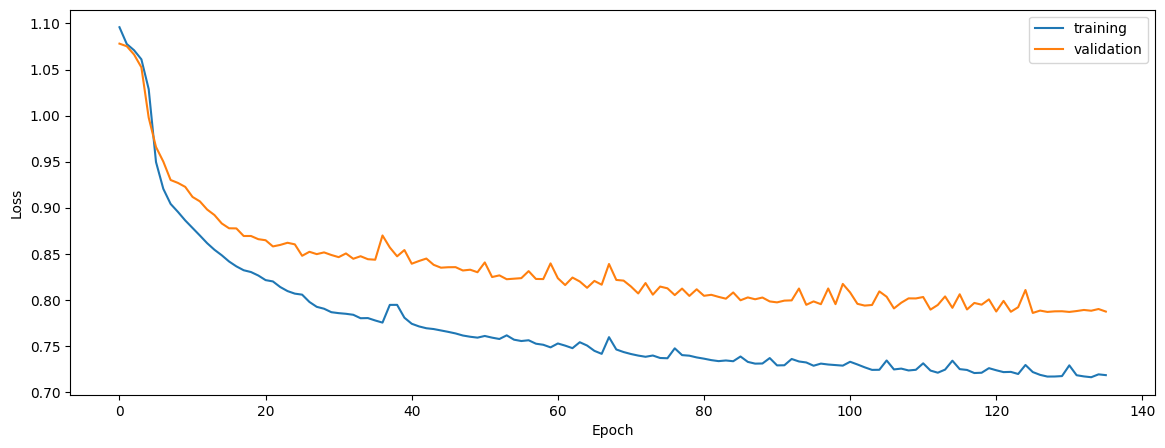

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6837930231453953


0.6600566021850774


0.66153832788936


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7212368396092194


0.6847715044609413


0.7003251320128208


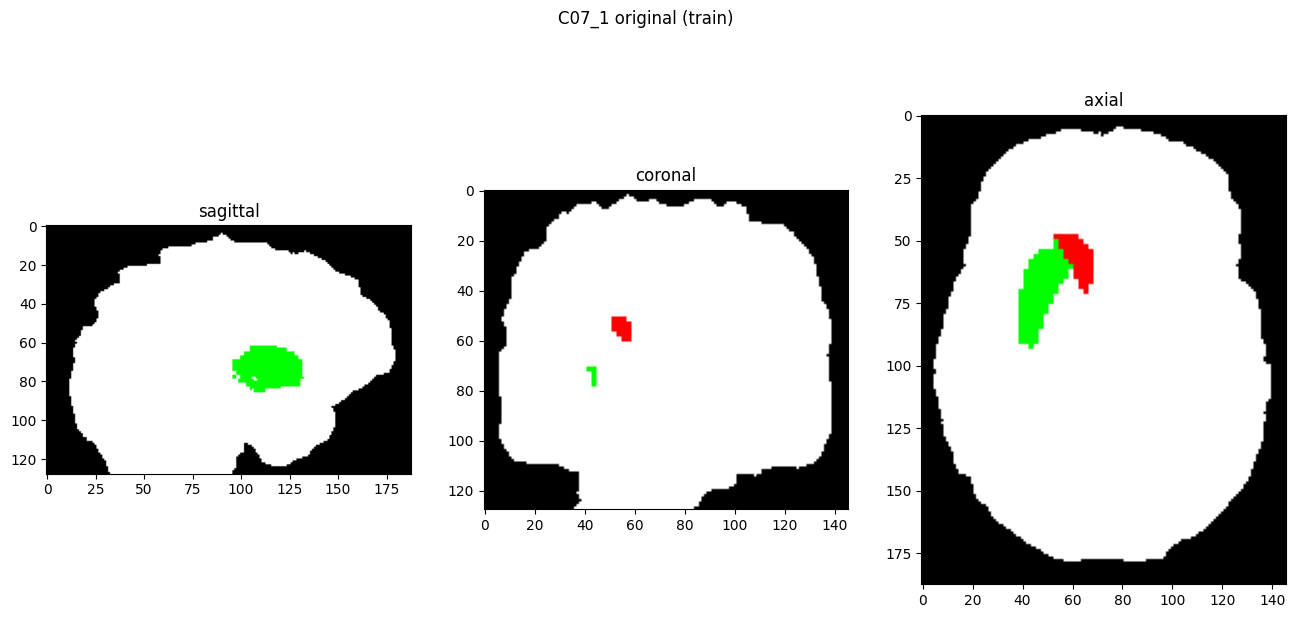

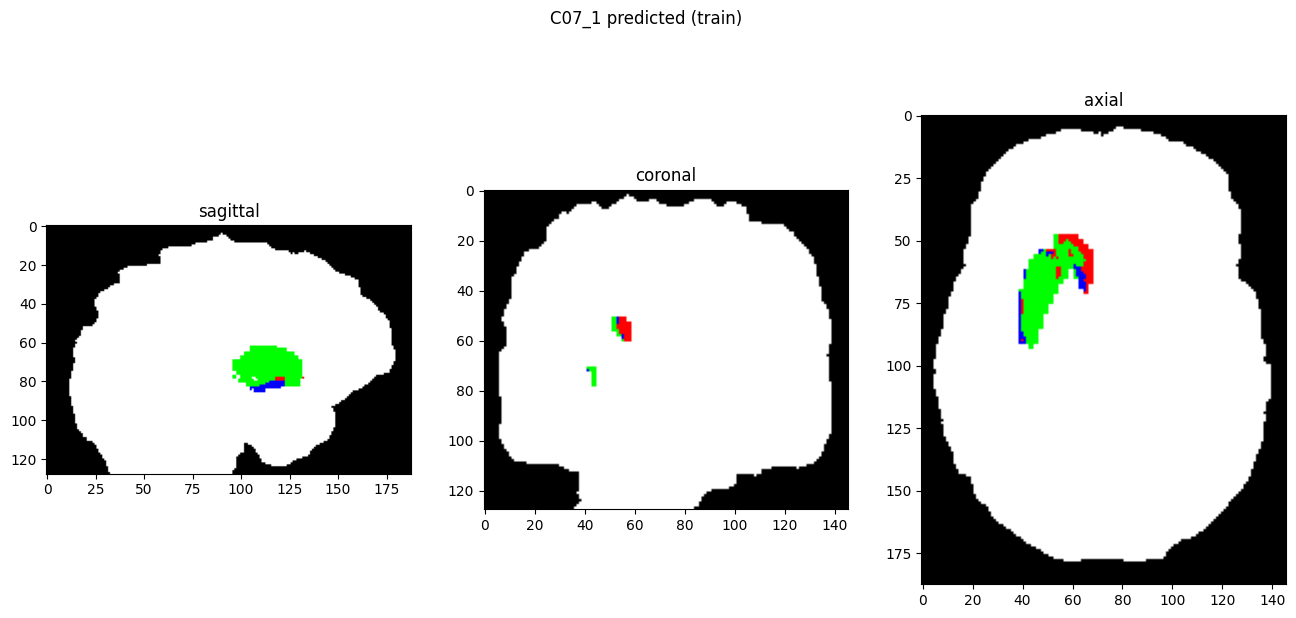

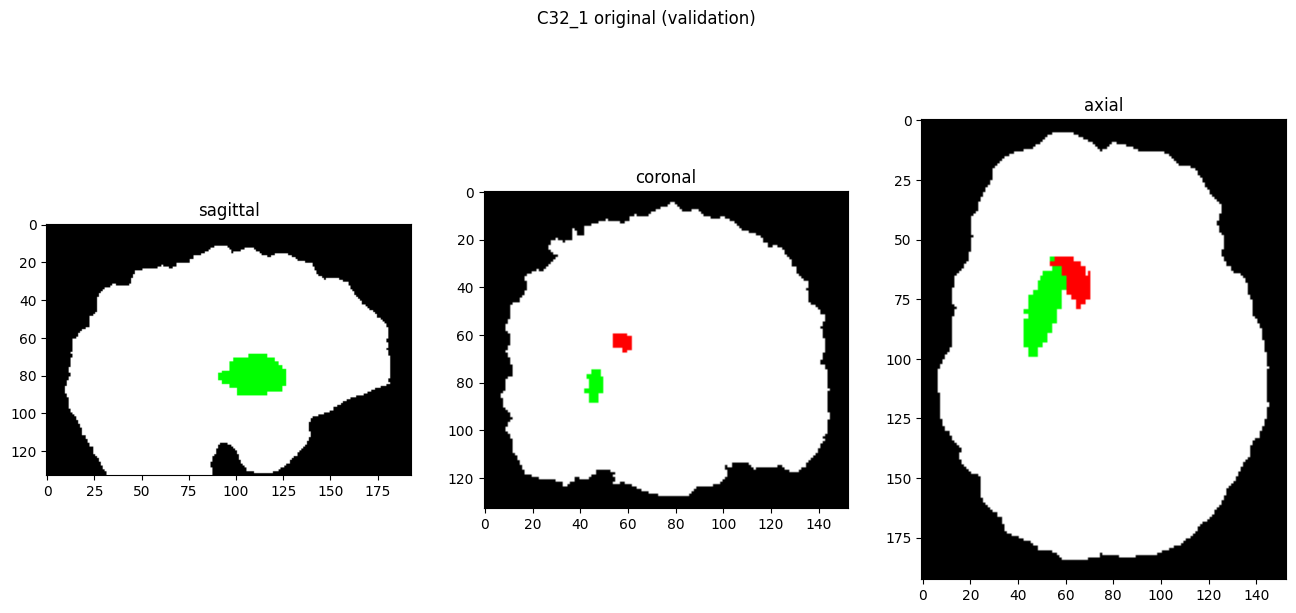

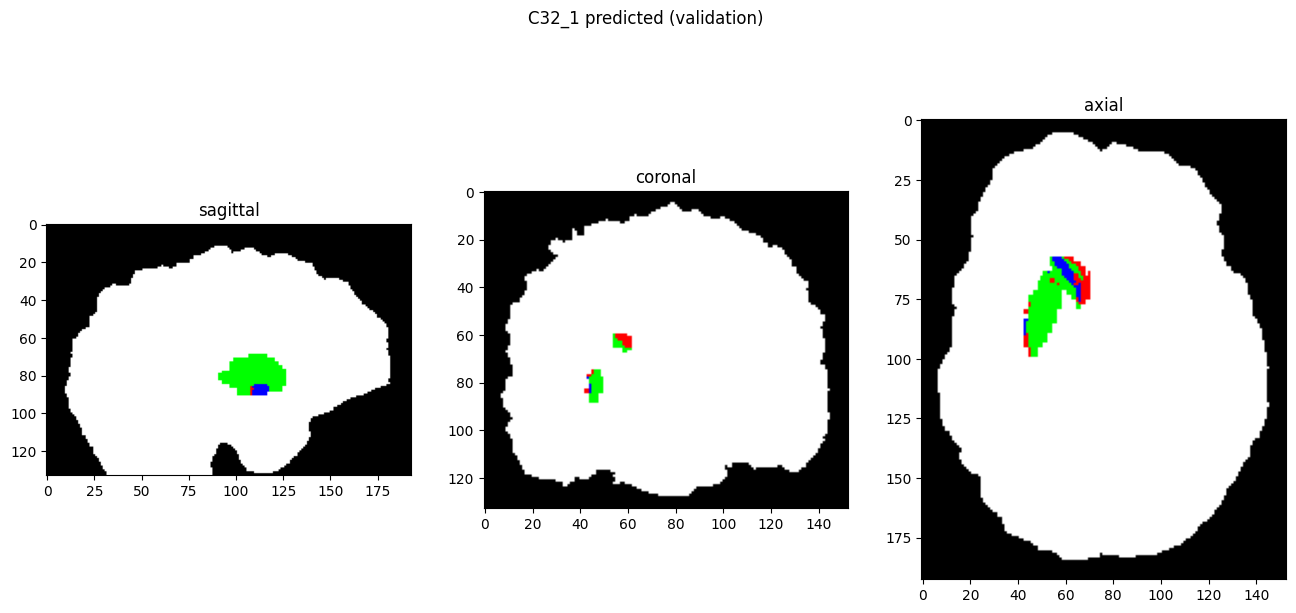

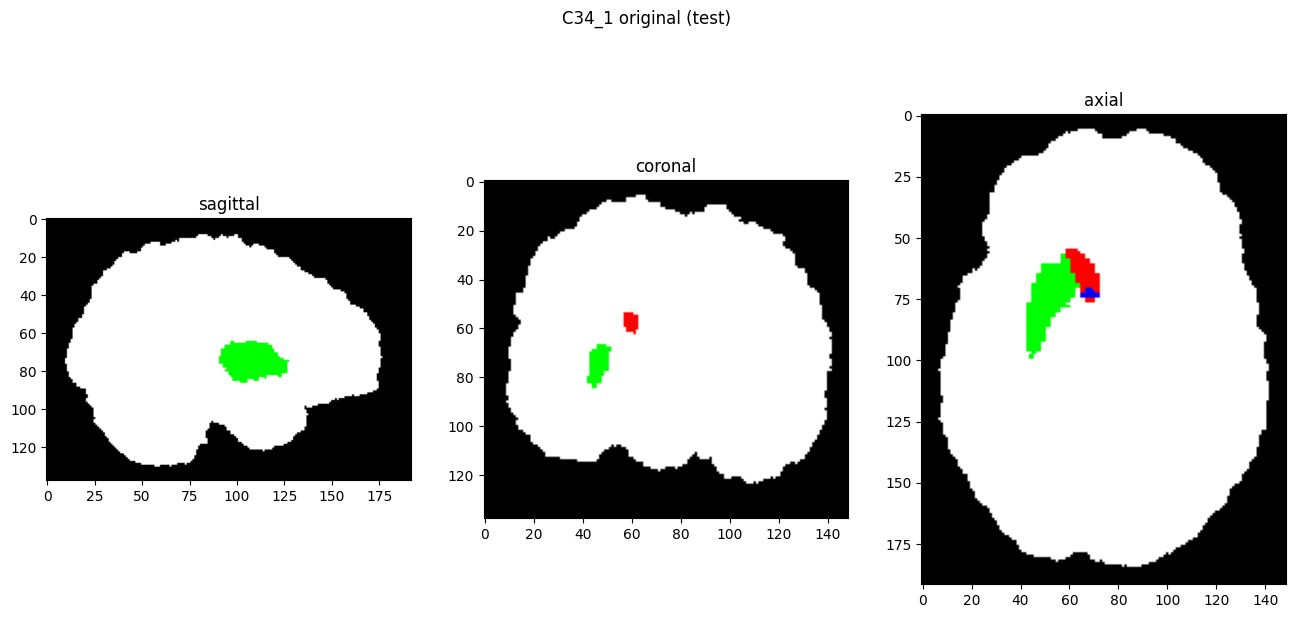

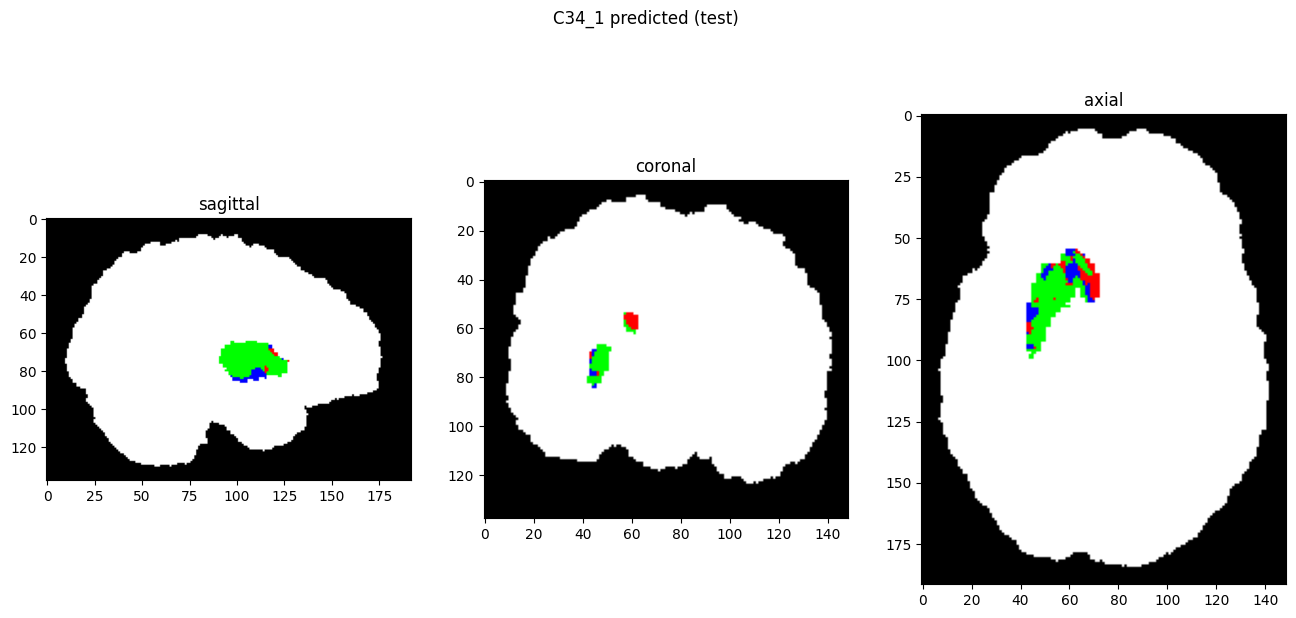

In [9]:
showResults(model, gen, threshold=0)